<a href="https://colab.research.google.com/github/jmaloon1/Python-Connect4-NN/blob/main/Connect_4_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [7]:
import pygame
import random
import math
import time
import numpy as np
import copy
from enum import Enum
import heapq
import psutil

from collections import namedtuple, deque
from itertools import chain
from IPython.display import display, HTML
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False, precision=2)
import os

display(HTML("<style>.container { width:90% !important; }</style>"))
torch.set_printoptions(sci_mode=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Class that holds state of the Game

In [19]:
class CFGame:
    def __init__(self, num_rows=6, num_cols=7, in_a_row=4):
        self.num_rows = num_rows   # Number of rows in board
        self.num_cols = num_cols   # Number of columns in board
        self.in_a_row = in_a_row    # Number of pieces in a row to win
        self.move_num = 0   # Number of moves played in game
        self.state = [[0]*self.num_rows for i in range(self.num_cols)] # Game Board -> (i,j) where i is columns and j is row. Initializing to 0's. Red's moves will be denoted 1 and black's -1
        self.moves_played = [-1]*self.num_cols*self.num_rows   # Columns played in order. Initializing to -1's
        self.red_turn = True  # True if it is reds turn
        #self.played = None    # True if move has been made

        self.forward_diagonal_count = [[1]*self.num_rows for i in range(self.num_cols)]   # Number of squares in a row for each square in forward diagonal(/)
        self.forward_diagonal_index = [[0]*self.num_rows for i in range(self.num_cols)]
        for x in range(self.num_cols):
            for y in range(self.num_rows):
                self.forward_diagonal_index[x][y] = x + (self.num_rows-y)
                for i in range(x+1, self.num_cols):
                    for j in range(y+1, self.num_rows):
                        if i-x==j-y:
                            self.forward_diagonal_count[x][y]+=1
                            self.forward_diagonal_count[i][j]+=1

        self.backward_diagonal_count = [[1]*self.num_rows for i in range(self.num_cols)]   # Number of squares in a row for each square in backward diagonal(\)
        self.backward_diagonal_index = [[0]*self.num_rows for i in range(self.num_cols)]
        for x in range(self.num_cols):
            for y in range(self.num_rows-1, -1, -1):
                self.backward_diagonal_index[x][y] =  self.num_cols-x + (self.num_rows-y-1)
                for i in range(x+1, self.num_cols):
                    for j in range(y-1, -1, -1):
                        if i+j==x+y:
                            self.backward_diagonal_count[x][y]+=1
                            self.backward_diagonal_count[i][j]+=1

    def get_state(self):
        # Returning state
        return self.state.copy()

    def is_red_turn(self):
        # Returning bool for whether it is red's turn
        return self.red_turn

    def get_num_rows(self):
        # Returning number of rows on board
        return self.num_rows

    def get_num_cols(self):
        # Returning number of columns on board
        return self.num_cols

    def full_column(self, column):
        """ checking whether a column is full
        Args:
            column: column to be played
        Returns:
            boolean that is True if the column is full and False otherwise
        """
        if column<0 or column>self.num_cols or self.state[column][self.num_rows-1]!=0:
            return True

        return False

    def moves_played_updater(self, column, undo):
        """ updating the moves played within a game
        Args:
            column: column to be added or removed to current array with previous game moves
            undo: boolean that is True if we are undoing a move and False otherwise
        """
        if not undo:
            self.moves_played[self.move_num] = column
            self.move_num+=1
        else:
            self.move_num-=1
            self.moves_played[self.move_num] = -1

    def play(self, column, out_of_turn=False):
        """ playing a move if it is legal
        Args:
            column: column to be played
            out_of_turn: boolean that is True if the move is out of turn and False otherwise
        Returns:
            boolean that is True if the move is played and False otherwise
        """
        played = False

        if column<0 or column>self.num_cols or self.full_column(column):  # Return False if column cannot be played
            return False

        for row in range(self.num_rows):
            if self.state[column][row]==0:  # If row can be played, play it and update game status
                if self.is_red_turn() and not out_of_turn:
                    self.state[column][row] = 1
                    self.moves_played_updater(column, False)  # Updating game moves
                    played = True
                    self.red_turn = False
                elif not self.is_red_turn() and not played and not out_of_turn:
                    self.state[column][row] = -1
                    self.moves_played_updater(column, False)  # Updating game moves
                    played = True
                    self.red_turn = True
                elif self.is_red_turn() and out_of_turn:
                    self.state[column][row] = -1
                    self.moves_played_updater(column, False)  # Updating game moves
                    played = True
                    self.red_turn = False
                elif not self.is_red_turn() and not played and out_of_turn:
                    self.state[column][row] = 1
                    self.moves_played_updater(column, False)  # Updating game moves
                    played = True
                    self.red_turn = True

                return True

        return True

    def unplay(self, column):
        """ Undoing a move
        Args:
            column: column to be unplayed
        Returns:
            boolean that is True if the move is unplayed and False otherwise
        """

        if column<0 or column>self.num_cols or self.state[column][0]==0:  # Return False if column cannot be unplayed
            return False

        for row in range(self.num_rows-1, -1, -1):  # Starting at top of board and moving to bottom
            if self.state[column][row]!=0:  # If row can be unplayed, unplay it and update game status
                self.state[column][row] = 0
                self.moves_played_updater(column, True)
                if self.is_red_turn():
                    self.red_turn = False
                else:
                    self.red_turn = True
                break
        #print("state after removing: " + str(self.state))
        return True

    def is_four_in_a_row(self, column):
        """ Returning whether there is a winner on given board
        Args:
            board: game board
            column: column that was just played
            row: row that was just played
        Returns:
            boolean that is True if there is a winner and False otherwise
        """

        setup_time = time.time()
        val = next((i for i, x in enumerate(self.state[column]) if not x), None)
        if val and column!=-1:
            row = val-1  # row of last move played
            #print("rr: " + str(row))
        elif column==-1:
            return False
        else:
            row = self.num_rows-1

        #print("setup time: " + str(time.time()-setup_time))

        last_played_value = self.state[column][row]

        # Checking up column
        column_time = time.time()
        if row>=self.in_a_row-1:
            n_in_a_row = 1  # Starting with 1 in a row
            for j in range(row-1, -1, -1):   # Checking down column from where move was made
                if self.state[column][j]==last_played_value:
                    n_in_a_row+=1
                    if n_in_a_row>=self.in_a_row:
                        return True
                else:
                    break
        #print("column time: " + str(time.time()-column_time))

        rownew_time = time.time()
        look_left = True
        look_right = True
        n_in_a_row = 1
        for i in range(1, self.in_a_row):
            if look_left:
                if column-i>=0 and self.state[column-i][row]==last_played_value:
                    n_in_a_row+=1
                    if n_in_a_row>=self.in_a_row:
                        return True
                else:
                    look_left = False
            if look_right:
                if (column+i)<self.num_cols and self.state[column+i][row]==last_played_value:
                    n_in_a_row+=1
                    if n_in_a_row>=self.in_a_row:
                        return True
                else:
                    look_right = False

            if not look_left and not look_right:
                break

        #print("rownew time: " + str(time.time()-rownew_time))

        if self.move_num >= self.in_a_row*(self.in_a_row+1)/2:   # Only if enough moves have been played
            """
            fd_time = time.time()
            n_in_a_row = 0  # Starting with 0 in a row
            for x in range(self.get_num_cols()):   # Checking across from where move was made
                y = row-(column-x)
                if x-y==column-row and y>=0 and y<self.get_num_rows() and self.get_state()[x][y]==self.get_state()[column][row]:
                    n_in_a_row+=1
                    if n_in_a_row>=self.in_a_row:
                        #print("new diag")
                        #print(self.state)
                        return True
                else:
                    if x>=self.get_num_cols()-self.in_a_row:
                        break
                    n_in_a_row = 0
            print("fd: " + str(time.time()-fd_time))
            """

            # Forward diagonal (/)
            fd_new_time = time.time()
            n_in_a_row = 1
            look_left = True
            look_right = True
            for i in range(1, self.in_a_row):
                if look_left:
                    if (column-i)>=0 and (row-i)>=0 and self.state[column-i][row-i]==last_played_value:
                        n_in_a_row+=1
                        if n_in_a_row>=self.in_a_row:
                            return True
                    else:
                        look_left = False
                if look_right:
                    if (column+i)<self.num_cols and (row+i)<self.num_rows and self.state[column+i][row+i]==last_played_value:
                        n_in_a_row+=1
                        if n_in_a_row>=self.in_a_row:
                            return True
                    else:
                        look_right = False

                if not look_left and not look_right:
                    break
            ##print("fdnew: " + str(time.time()-fd_new_time))

            """ OLD
            bd_time = time.time()
            # Backward diagonal
            n_in_a_row = 0  # Starting with 0 in a row
            for x in range(self.get_num_cols()):   # Checking across from where move was made
                y = row+(column-x)
                if x+y==column+row and y>=0 and y<self.get_num_rows() and self.get_state()[x][y]==self.get_state()[column][row]:
                    n_in_a_row+=1
                    if n_in_a_row>=self.in_a_row:
                        return True
                else:
                    if x>=self.get_num_cols()-self.in_a_row:
                        break
                    n_in_a_row = 0
            print("bd: " + str(time.time()-bd_time))
            """

            bd_new_time = time.time()
            n_in_a_row = 1
            look_left = True
            look_right = True
            for i in range(1, self.in_a_row):
                if look_left:
                    if (column-i)>=0 and (row+i)<self.num_rows  and self.state[column-i][row+i]==last_played_value:
                        n_in_a_row+=1
                        if n_in_a_row>=self.in_a_row:
                            return True
                    else:
                        look_left = False
                if look_right:
                    if (column+i)<self.num_cols and (row-i)>=0 and self.state[column+i][row-i]==last_played_value:
                        n_in_a_row+=1
                        if n_in_a_row>=self.in_a_row:
                            return True
                    else:
                        look_right = False

                if not look_left and not look_right:
                    break
            #print("bdnew: " + str(time.time()-bd_new_time))

        return False

    def is_game_over(self):
        """ Returning whether or not the game is over
        Returns:
            boolean that is True if the game is over and False otherwise
        """
        #if self.is_winner():  # If there is a winner, return True
        if self.is_four_in_a_row(self.moves_played[self.move_num-1]):
            return True

        for k in range(self.num_cols):  # If an entry in the top row is unplayed, return False
            if self.state[k][self.num_rows-1]==0:
                return False

        return True   # For a draw

    def winner(self):
        """ Returning Number of Winner (1 for red, -1 for black, 0 for draw)
        Returns:
            int representing winner
        """
        if self.is_game_over() and self.is_four_in_a_row(self.moves_played[self.move_num-1]):
            if not self.is_red_turn():   # If black is to play (so red made last move), red won
                return 1
            else:
                return -1

        return 0   # for a draw

    def print_game_moves(self):
        # Printing game moves
        for move in self.moves_played:
            print(str(move) + ", ")

        print("")



In [9]:
class ConsoleCF(CFGame):
    def __init__(self, ai1=None, ai2=None, nn_ai=False, num_rows=6, num_cols=7, in_a_row=4, goes_first=0, debugging_game=False, pre_moves=[], print_values=False):
        super().__init__(num_rows, num_cols, in_a_row)
        #self.game = CFGame()
        self.human_vs_human = False
        self.human_vs_AI = False
        self.AI_vs_AI = False
        self.debugging_game = debugging_game
        self.pre_moves = pre_moves
        self.ai1_first = False
        self.hp1_first = False
        self.game_moves = []
        self.move_number = 0
        self.hp1 = None
        self.hp2 = None
        self.ai1 = ai1
        self.ai2 = ai2
        self.nn_ai = nn_ai    # If for neural network
        self.goes_first = goes_first  # 0 for random, 1 for player 1, 2 for player 2
        self.print_values = print_values

        if self.ai1==None:   # If no AI inputted, human vs. human game
            self.human_vs_human = True
        elif self.ai2==None:   # If one AI inputted, human vs. AI game
            self.human_vs_AI = True
        elif self.ai2!=None or self.debugging_game:    # If two AI inputted, AI vs. AI game
            self.AI_vs_AI = True

        if self.AI_vs_AI and not self.debugging_game and self.pre_moves:   # If debugging game, play moves and return
            for i in range(len(self.pre_moves)):
                self.play(self.pre_moves[i])

        if self.human_vs_human:
            self.hp1 = self.HumanPlayer()
            self.hp2 = self.HumanPlayer()

            if (self.goes_first==0 and random.randint(0,1)==0) or self.goes_first==1:  # Change to ==
                self.hp1_first = True

            print("What is Player 1's name: ")
            self.hp1.player_name = input()

            print("")
            print("What is Player 2's name: ")
            self.hp2.player_name = input()

            if self.hp1.player_name==self.hp2.player_name:  # If names are the same then adding 1 or 2 at the end to differntiate
                self.hp1.player_name+="1"
                self.hp2.player_name+="2"

            print("Press the number (1-x from left to right) of the corresponding column to play a move ")

            if self.hp1_first:
                self.board_print()
                self.play(self.hp1.next_move(self)-1)
        elif self.human_vs_AI:
            self.hp1 = self.HumanPlayer()

            if (self.goes_first==0 and random.randint(0,1)==0) or self.goes_first==1:  # Change
                self.hp1_first = True
            else:
                self.ai1_first = True
        elif self.AI_vs_AI:
            self.ai1_first = True if (self.goes_first==0 and random.randint(0,1)==0) or self.goes_first==1 or self.debugging_game else False

    def play_out(self, ai1_epsilon=0, ai2_epsilon=0):
        # Playing a game to completion
        if self.debugging_game:   # If debugging game, play moves and return
            for i in range(len(self.pre_moves)):
                if i%2==0:
                    self.ai1.next_move(self, ai1_epsilon)
                    self.play(self.pre_moves[i])
                    self.board_print()
                else:
                    self.ai2.next_move(self, ai2_epsilon)
                    self.play(self.pre_moves[i])
                    self.board_print()

            return

        if self.ai1_first and not self.human_vs_human:
            self.play(self.ai1.next_move(self, ai1_epsilon))

        while not self.is_game_over():
            if self.human_vs_human:
                self.board_print()
                self.play(self.hp2.next_move(self)-1)

                if not self.is_game_over():
                    self.board_print()
                    self.play(self.hp1.next_move(self)-1)
                if self.is_game_over():
                    self.board_print()

            if self.human_vs_AI:
                self.board_print()
                self.play(self.hp1.next_move(self)-1)

                if not self.is_game_over():
                    self.play(self.ai1.next_move(self, ai1_epsilon))
                if self.is_game_over():
                    self.board_print()

            if self.AI_vs_AI:
                self.play(self.ai2.next_move(self, ai2_epsilon))
                if self.print_values:
                    self.board_print()
                if not self.is_game_over():
                    self.play(self.ai1.next_move(self, ai1_epsilon))
                    if self.print_values:
                        self.board_print()

            if self.debugging_game:
                self.ai1.next_move(self, ai1_epsilon)
                self.play(self.game_moves[self.move_number])
                self.board_print()
                self.move_number+=1

    def get_winner(self):
        """ Returning winner of game or if it was a draw
        Returns:
            string representing winner
        """
        ##### Important: current mover is already updated so logic may look backwards but is not
        if self.human_vs_human:
            if self.winner()==0:
                return "Draw"
            elif (self.is_red_turn() and not self.hp1_first) or (not self.is_red_turn() and self.hp1_first):
                return self.hp1.get_name()
            else:
                return self.hp2.get_name()

        if self.human_vs_AI:
            if self.winner()==0:
                return "Draw"
            elif (self.is_red_turn() and self.ai1_first) or (not self.is_red_turn() and not self.ai1_first):   # Human First Human wins = NOT self.ai1_first and NOT self.isredturn
                return self.hp1.get_name()
            else:
                return self.ai1.get_name()

        if self.AI_vs_AI:
            if self.winner()==0:
                return "Draw"
            elif (self.is_red_turn() and not self.ai1_first) or (not self.is_red_turn() and self.ai1_first):    # FIXED
                return self.ai1.get_name()
            else:
                return self.ai2.get_name()

        if self.debugging_game:
            if self.winner()==0:
                return "Draw"
            elif (not self.is_red_turn() and self.ai1_first) or (self.is_red_turn() and not self.ai1_first):
                return "non-AI"
            else:
                return self.ai1.get_name()

        return "error"

    def board_print(self):
        s = self.get_state()

        for r in range(self.get_num_rows()-1, -1, -1):
            for c in range(self.get_num_cols()):
               # print(("  " if len(str(s[c][r]))==1 else " ") + str('X' if s[c][r]==1 else 'O' if s[c][r]==-1 else '-'), end=" ")
                print(" " + str('X' if s[c][r]==1 else 'O' if s[c][r]==-1 else '-'), end=" ")
            print("")
        print("")

    class HumanPlayer():
        def __init__(self):
            #super().__init__()
            self.player_name = "Human Player"

        def next_move(self, g):
            """ Returning winner of game or if it was a draw
            Args:
                g: instance of CFGame
            Returns:
                col: column to be played
            """
            game_board = g.get_state()

            print("What column would " + self.get_name() + " like to play: ")
            col = input()
            while not col.isdigit():
                print("Type an integer: ")
                col = input()

            col = int(col)

            while col<1 or col>g.get_num_cols() or (game_board[col-1][g.get_num_rows()-1] != 0 and not g.is_game_over()):
                print("Illegal Move. What column would you like to play: ")
                col = input()
                while not col.isdigit():
                    print("Type an integer: ")
                    col = input()

                col = int(col)

            return col

        def get_name(self):
            """ Returning player name
            Returns:
                string of player name
            """
            return self.player_name


In [10]:
class RandomAI():
    def __init__(self):
        pass

    def next_move(self, game, epsilon=0):
        legal_moves = [index for index, column in enumerate(game.get_state()) if column[-1]==0]   # illegal_moves
        return random.choice(legal_moves)

    def get_name(self):
        return "RandomAI"

In [11]:
class JackAI():
    class Node:
        def __init__(self, parent=None, move=None, depth=0, value=0):
            self.parent = parent
            self.children = []
            self.move = move
            self.value = value
            self.depth = depth

    def __init__(self, sim_mode, mm):
        self.sim_mode = sim_mode
        self.mm = mm
        #self.g = g

    def minimax(self, node, is_max_player, max_depth=5):
        if node.depth==max_depth or len(node.children)==0:   # Return value if we are at end of tree
            return node.value

        if is_max_player:
            max_val = -1*float('inf')
            for child in node.children:
                val = self.minimax(child, is_max_player=False)
                max_val = max(max_val, val)

            return max_val

        if not is_max_player:
            min_val = float('inf')
            for child in node.children:
                val = self.minimax(child, is_max_player=True)
                min_val = min(min_val, val)

            return min_val

        return node.value

    def next_move(self, g, epsilon=0):
        """ Simulates several moves in advance (if sim_mode true) and will return a column to be played based on logic in  moveFinder
        Args:
            column: column of move to be simulated
        Returns:
            int of column to be played
        """
        a = time.time()
        mf = self.moveFinder(g)   # Instance of moveFinder class
        moves_played = []    # Columns of moves simulated
        good_columns = []   # Will hold columns of moves that causes ai (going first) to win against itself
        bad_columns = []    # Will hold columns of moves that causes ai (going first) to lose against itself
        ai_num = -1
        opp_first_move = -1
        good_first_moves = {}
        index = None


        win_finder = mf.find_winning_column()
        if win_finder!=-1:
            print("Playing winning/blocking move: " + str(win_finder))
            return win_finder
        else:   # If sim_mode is on, simulating moves ahead
            winning_starting_moves = set()
            losing_starting_moves = set()

            if self.mm:  # If using minimax
                head_node = self.Node()
                possible_win = False
                five_start = time.time()
                five_time = 0

                for i1 in range(g.get_num_cols()):
                    if not g.play(i1):  # Playing move
                        #head_node.children.append(self.Node(parent=head_node, move=i1, depth=1))  # So we always ave 7 elements in head children list
                        continue
                    else:
                        level1_node = self.Node(parent=head_node, move=i1, depth=1)
                        head_node.children.append(level1_node)

                        if g.is_game_over():  # Should never hit
                            level1_node.value = 1   # Represents a win
                            winning_starting_moves.add(i1)   # Could hit if very last move in game
                            possible_win = True
                            g.unplay(i1)
                            break    # Since we know there is at least 1 win and this is maximizing level, can leave loop
                        else:
                            for i2 in range(g.get_num_cols()):
                                if not g.play(i2):  # Playing move
                                    continue
                                else:
                                    level2_node = self.Node(parent=level1_node, move=i2, depth=2)
                                    level1_node.children.append(level2_node)
                                    if g.is_game_over():  # Should never hit
                                        ##print("loss")
                                        level2_node.value = -1   # Represents a loss
                                        possible_win = True
                                        g.unplay(i2)
                                        break    # Since we know there is at least 1 loss and this is minimizing level, can leave loop
                                    else:
                                         for i3 in range(g.get_num_cols()):
                                            if not g.play(i3):  # Playing move
                                                continue
                                            else:
                                                level3_node = self.Node(parent=level2_node, move=i3, depth=3)
                                                level2_node.children.append(level3_node)
                                                if g.is_game_over():
                                                    level3_node.value = 1   # Represents a win
                                                    possible_win = True
                                                    g.unplay(i3)
                                                    break    # Since we know there is at least 1 win and this is maximizing level, can leave loop
                                                else:
                                                    for i4 in range(g.get_num_cols()):
                                                        if not g.play(i4):  # Playing move
                                                            continue
                                                        else:
                                                            level4_node = self.Node(parent=level3_node, move=i4, depth=4)
                                                            level3_node.children.append(level4_node)
                                                            if g.is_game_over():
                                                                level4_node.value = -1   # Represents a loss
                                                                possible_win = True
                                                                g.unplay(i4)
                                                                break    # Since we know there is at least 1 loss and this is minimizing level, can leave loop
                                                            else:
                                                                for i5 in range(g.get_num_cols()):
                                                                    if not g.play(i5):  # Playing move
                                                                        continue
                                                                    else:
                                                                        level5_node = self.Node(parent=level4_node, move=i5, depth=5)
                                                                        level4_node.children.append(level5_node)
                                                                        if g.is_game_over():
                                                                            five_time+=time.time()-five_start
                                                                            five_start = time.time()
                                                                            level5_node.value = 1   # Represents a win
                                                                            possible_win = True
                                                                            g.unplay(i5)
                                                                            break    # Since we know there is at least 1 win and this is maximizing level, can leave loop

                                                                        g.unplay(i5)
                                                            g.unplay(i4)
                                                g.unplay(i3)
                                    g.unplay(i2)
                    g.unplay(i1)
                b = time.time()
                if possible_win:
                    for num in range(len(head_node.children)):
                        move = head_node.children[num].move
                        mm_res = self.minimax(head_node.children[num], is_max_player=False)
                        if mm_res > 0:
                            ##print("minimax win: " + str(move))
                            winning_starting_moves.add(move)
                            mf.AI_winning_column.append(move)
                        elif mm_res < 0:
                            ##print("minimax loss: " + str(move))
                            losing_starting_moves.add(move)
                            mf.losing_moves.append(move)

                #print("mm time: " + str(time.time()-b))
                #print("Five time: " + str(five_time))

            for col in range(g.get_num_cols()):
                if(self.sim_mode and not g.full_column(col)):  # Simulating game moves
                    #print("State Before: " + str(g.get_state()))
                    g.play(col)
                    if not g.is_red_turn():
                        ai_num = 1

                    if not g.is_game_over():
                        for self.sim_move in range(10):
                            index = self.column_quality(g, self.moveFinder(g), False, [], [], [], [])
                            g.play(index)
                            moves_played.append(index)

                            if self.sim_move==0:
                                opp_first_move = index

                            if g.is_game_over():
                                if g.winner()!=0:   # Jack changed on 12/28/24

                                    if (g.is_red_turn() and ai_num==-1) or (not g.is_red_turn() and ai_num==1):
                                        good_columns.append(col)

                                        if col not in good_first_moves.keys():
                                            good_first_moves[col] = [opp_first_move]
                                        else:
                                            good_first_moves[col].append(opp_first_move)

                                    if(g.is_red_turn() and ai_num==1) or (not g.is_red_turn() and ai_num==-1):
                                        bad_columns.append(col)

                                break
                    #print("State After sim: " + str(g.get_state()))
                    #print("moves played: " + str(moves_played))
                    for num in moves_played:
                        g.unplay(num)
                    #print("State After cleanup: " + str(g.get_state()))
                    moves_played = []
                    g.unplay(col)

            temp_good = good_columns.copy()
            test_bad_columns = []

            if len(temp_good) > 0:
                for col_index in temp_good:

                    if(self.sim_mode and not g.full_column(col_index)):
                        g.play(col_index)

                        for col in range(g.get_num_cols()):
                            if not g.full_column(col):

                                g.play(col)

                                if g.is_red_turn():
                                    ai_num = -1
                                else:
                                    ai_num = 1

                                if not g.is_game_over():
                                    for sim_move in range(10):
                                        index = self.column_quality(g, self.moveFinder(g), False, [], [], [], [])
                                        g.play(index)
                                        moves_played.append(index)

                                        if g.is_game_over():
                                            if g.winner()!=0:   # Jack changed on 12/28/24
                                                if g.is_red_turn() and ai_num==1 or not g.is_red_turn() and ai_num==-1:
                                                    test_bad_columns.append(col)

                                            break

                                for num in moves_played:
                                    g.unplay(num)

                                moves_played = []
                                g.unplay(col)

                        g.unplay(col_index)

                    if good_first_moves[col_index] in test_bad_columns:
                        del good_columns[col_index]


            return(self.column_quality(g, self.moveFinder(g), True, good_columns, bad_columns, winning_starting_moves, losing_starting_moves, a))

    def column_quality(self, g, mf, print_values, good_sim_columns, bad_sim_columns, winning_starting_moves, losing_starting_moves, tm=None):
        """ Scores each column to decide which move to play
        Args:
             g: instance of CFGame class that holds logic behind game
             m: instance of moveFinder inner class that holds logic behind each potential move
             print_values: boolean that will print values of ArrayLists from moveFinder if true
             good_sim_columns: List of moves in which AI beat itself when going first
             bad_sim_columns: List of moves in which AI lost to itself when going first
        Returns:
            int of column to be played
        """

        index = mf.find_winning_column()   # Function that finds winning moves, moves to avoid losing, and also columns that are winnable
        quality_array = [0,1,3,7,3,1,0]    # Assigning starting values to quality array that skew towards the center. This array will  determine which col to play
        mf.AI_winning_column.extend(winning_starting_moves)     # From minimax
        mf.losing_moves.extend(losing_starting_moves)          # From minimax

        if index!=-1:      # Looks to see if there is a column that can be played that guarantees win
            return index
        else:
            c = time.time()
            for col in range(g.get_num_cols()):   # plays winning move if possible
                mf.pretend_play(col, False)    # Running at .01 every time. Vrey slow
            #print("pretend_play first total: " + str(time.time()-c))

            for col in range(g.get_num_cols()):  # blocks opponent winning move if possible
                mf.pretend_play(col, True)   # Running at .003. Pretty good
                #quality_array[col] += mf.num_touching

            if(print_values):  # printing values in various ArrayLists
                print("good sim columns " + str(good_sim_columns))
                print("bad sim columns " + str(bad_sim_columns))
                print("losing moves " + str(mf.losing_moves))
                print("unwise moves " + str(mf.unwise_moves))
                print("sacrifice moves " + str(mf.sacrifice_moves))
                print("illegal moves " + str(mf.illegal_moves))
                print("three_preventable " + str(mf.three_preventer))
                print("bad position " + str(mf.bad_position))
                print("best ai  unblockable " + str(mf.best_AI_unblockable))
                print("best opp unblockable " + str(mf.best_opp_unblockable))
                print("ok ai  unblockable " + str(mf.ok_AI_unblockable))
                print("ok opp unblockable " + str(mf.ok_opp_unblockable))
                print("ai blockable " + str(mf.AI_blockable))
                print("opp blockable " + str(mf.opp_blockable))
                print("AI winning column " + str(mf.AI_winning_column))
                print("opp winning column " + str(mf.opp_winning_column))
                print("loss avoider " + str(mf.loss_avoider))
                print("loss creator " + str(mf.loss_creator))
                #print("num touching " + str(mf.num_touching))

            ##if tm != None:
                ##print("full move time: " + str(time.time()-tm))
            return self.max_element_array(quality_array, good_sim_columns, bad_sim_columns, mf.illegal_moves, mf.losing_moves, mf.unwise_moves, mf.sacrifice_moves,
                    mf.bad_setup, mf.loss_avoider, mf.loss_creator, mf.best_AI_unblockable, mf.best_opp_unblockable, mf.ok_AI_unblockable, mf.ok_opp_unblockable,
                    mf.AI_blockable, mf.opp_blockable, mf.AI_winning_column, mf.opp_winning_column, mf.three_preventer, mf.bad_position, mf.four_map, mf.num_touching)

    def max_element_array(self, quality_arr, good_sim_columns, bad_sim_columns, illegal_moves, losing_moves, unwise_moves, sacrifice_moves, bad_setup,
                          loss_avoider, loss_creator, best_AI_unblockable, best_opp_unblockable, ok_AI_unblockable, ok_opp_unblockable, ai_blockable, opp_blockable,
                          AI_winning_column, opp_winning_column, three_preventable, bad_position, four_potential_map, num_touching):
        """ Creates instance of moveFinder inner class to gather logic based on differnt potential moves
        Args:
             Lists of different game attriubtes
        Returns:
            int of column to be played
        """

        # Values assigned to columns from different lists. Negative means bad (the more negative the worse) and positive is good (the more positive the better)
        max_val = -1000000
        max_element = 0
        illegal = -10000
        losing = -1000
        unwise = -150
        loss_finder = 500
        loss_maker = -500
        block_opponent_three = -7
        ai_three_best = 40
        opp_three_best  = 30
        ai_three_ok = 24
        opp_three_ok  = 16
        three_grouped_blockable = 7
        opponent_three_blockable  = 5
        good_column = 50
        great_column = 400
        bad_place = -50
        sacrifice = 20
        poor_setup = -50
        touching = 2

        duplicate_max = []

        for index in good_sim_columns:    # Adding positive value to a column in which AI going first beat itself
            quality_arr[index] += good_column

        for index in bad_sim_columns:    # Adding negative value to a column in which AI going first lost to itself
            quality_arr[index] += unwise

        for index in unwise_moves:    # Adding negative value to a move that allows opponent to block aAI winning move
            quality_arr[index] += unwise

        for index in sacrifice_moves:    # Adding positive value to a column that allows opponent to block AI's winning move to create better winning move
            quality_arr[index] += sacrifice

        for index in bad_setup:    # Adding negative value to a column that creates a good board setup for opponent
            quality_arr[index] += poor_setup

        for index in loss_avoider:    # Adding positive value to a column move that avoids loss for AI
            quality_arr[index] += loss_finder

        for index in loss_creator:    # Adding negative value to a column that allows opponent to make create a board that they can immediately win on
            quality_arr[index] += loss_maker

        for index in best_AI_unblockable:    # Adding positive value to making three in a row that can't be blocked with potential winning move on good row
            quality_arr[index] += ai_three_best

        for index in best_opp_unblockable:    # Adding positive value to blocking opponent three in a row that can't be blocked with potential winning move on good row
            quality_arr[index] += opp_three_best

        for index in ok_AI_unblockable:    # Adding positive value to making three in a row that can't be blocked with potential winning move on bad row
            quality_arr[index] += ai_three_ok

        for index in ok_opp_unblockable:    # Adding positive value to blocking opponent three in a row that can't be blocked with potential winning move on bad row
            quality_arr[index] += opp_three_ok

        for index in ai_blockable:    # Adding positive value to making three in a row that can be blocked
            quality_arr[index] += three_grouped_blockable

        for index in opp_blockable:   # Adding positive value to blocking opponent three in a row that can be blocked
            quality_arr[index] += opponent_three_blockable

        for index in three_preventable:    # Adding negative value to a column that allows opponent to make three in a row
            quality_arr[index] += block_opponent_three

        for index in bad_position:    # Adding negative value to move that sets up opponent in good position
            quality_arr[index] += bad_place

        for index in AI_winning_column:    # Adding value to a column that creates two winning moves on top of one another
            quality_arr[index] += great_column

        for index in opp_winning_column:    # Adding value to a column that blocks opponent from two winning moves on top of one another
            quality_arr[index] += great_column

        for k, v in num_touching.items():    # Adding value to a column that touches other filled squares
            quality_arr[k] += touching*v

        for index in losing_moves:    # Setting values of columns that allow opponent to win to large negative number
            quality_arr[index] = losing

        for index in illegal_moves:    # Setting values of columns that canoot be played to very large negative value if move is illegal
            quality_arr[index] = illegal


        for i in range(len(quality_arr)):    # iterates through array with values assigned to each column, find biggest value (best column)
            if quality_arr[i] > max_val:
                max_val = quality_arr[i]
                max_element = i
                if len(duplicate_max) > 0:
                    duplicate_max = []

            elif quality_arr[i] == max_val:
                duplicate_max.append(i)

                if len(duplicate_max) == 1:
                    duplicate_max.append(max_element)
        print("quality arr: " + str(quality_arr))

        if len(duplicate_max) > 0:
            r = random.randint(0, len(duplicate_max)-1)

            return duplicate_max[r]

        return max_element

    def get_name(self):
        """ Returns name of this AI
        Returns:
            String name of AI
        """
        if self.sim_mode:
            return "Jack Maloon better AI"
        else:
            return "Worse AI"

    class moveFinder():
        def __init__(self,  g):
            #a = time.time()
            #self.sim_mode = sim_mode             # Will be true if running simulation to avoid playing losing move
            self.g = g                           # Will be an instance of CFGame
            self.get_state = g.get_state()       # current board

            if g.is_red_turn():
                self.AI_color = 1                   # Color of AI (1 for red, -1 for black), will change depending on who goes first
                self.opp_color = -1                   # Color of opponent (1 for red, -1 for black), will change depending on who goes first
            else:
                self.AI_color = -1                   # Color of AI (1 for red, -1 for black), will change depending on who goes first
                self.opp_color = 1                   # Color of opponent (1 for red, -1 for black), will change depending on who goes first

            self.losing_moves = []              # List of moves that will allow opponent to win on following turn
            self.unwise_moves = []              # List of moves that will allow opponent to block Ai's potential winning move on following turn
            self.sacrifice_moves = []           # List of moves that will allow sacrifice one potential four in a row for a better setup
            self.bad_setup = set()              # Set of moves that will allow opponent to block Ai's potential winning setup
            self.illegal_moves = []             # List of moves that are illegal (column is full)
            self.best_AI_unblockable = []        # List of moves that will give AI three in a row that can't be immediately blocked
            self.best_opp_unblockable = []       # List of moves that will give opponent three in a row that can't be immediately blocked
            self.ok_AI_unblockable = []          # List of moves that will give AI three in a row that can't be immediately blocked
            self.ok_opp_unblockable = []         # List of moves that will give opponent three in a row that can't be immediately blocked
            self.AI_blockable = []               # List of moves that will give AI three in a row that can be immediately blocked
            self.opp_blockable = []              # List of moves that will give opponent three in a row that can't be immediately blocked
            self.loss_avoider = set()            # Set of moves that block opponent from developing a winning game board
            self.loss_creator = set()            # Set of moves that allow opponent from developing a winning game board
            self.three_preventer = []            # List of moves allow opponent to make three in a row or stop AI from doing so
            self.AI_winning_column = []           # List of moves in a column that allows for AI to win
            self.opp_winning_column= []          # List of moves in a column that allows for opp to win
            self.bad_position = []               # List of moves block opponent from three in a row unblockable in two directions
            self.winning_index = []              # List of columns thought to be winning columns
            self.not_winning_column = []         # List of columns thought to be winning columns
            self.AI_winnable_columns = {}        # Dict of columns that are already considered winning
            self.opp_winnable_columns = {}       # Dict of columns that are already considered winning
            self.three_map = [[0]*self.g.get_num_rows() for i in range(self.g.get_num_cols())]          # Nested List of where three in a row is possible at some point in game
            self.initial_four_map = self.board_four_map()   # Initial list of where four in a row is possible at some point in game
            self.four_map = self.board_four_map()           # List of where four in a row is possible at some point in game
            self.already_winning_column = False     # True if a winning column already exists
            self.num_touching = {x: 0 for x in range(self.g.get_num_cols())}    # Number of filled squares move will touch
            #print("init: " + str(time.time()-a))

        def pretend_play(self, column, opp_turn):
            """ Simulates a game move and test different criteria based on move
            Args:
                column: column of move to be simulated
                opp_turn: True if simulating opponent's turn, False otherwise
            Returns:
                boolean that is True if move can be played and False otherwise
            """
            total_start = time.time()
            board3_counter = 0
            destroy_counter = 0
            winning_counter = 0
            find_counter = 0
            if column<0 or column > self.g.get_num_cols() or self.g.full_column(column):   # If move cannot be made
                self.illegal_moves.append(column)
                return False

            #self.initial_four_map = self.board_four_map()

            for row in range(self.g.get_num_rows()-1, -1, -1):     # Simulates a move and what number will be played on move
                if self.get_state[column][row]==0:
                    if (self.g.is_red_turn() and not opp_turn) or (not self.g.is_red_turn() and opp_turn):  # Simulating a red move
                        self.get_state[column][row] = 1
                    else:    # Simulating a black move
                        self.get_state[column][row] = -1
                    board3_start = time.time()
                    if not opp_turn:
                        self.board_three_in_a_row(column, row, opp_turn, self.best_AI_unblockable, self.ok_AI_unblockable, self.AI_blockable) # If 3 out of four can be created for AI
                    else:
                        self.board_three_in_a_row(column, row, opp_turn, self.best_opp_unblockable, self.ok_opp_unblockable, self.opp_blockable) # If 3 out of four can be created for opp
                    board3_counter+=time.time()-board3_start
                    if row==0 or (row>0 and self.get_state[column][row-1]!=0):   # Checking conditions on simulated moves that can actually be played
                        if self.already_winning_column and opp_turn:    # Checking to see if column that is deemed winning is still so after opponent move
                            destroy_start = time.time()
                            self.destroy_winning_column(column, opp_turn)
                            destroy_counter+=time.time()-destroy_start
                        if not self.already_winning_column:   # If no winning columns exists from previous turns, looking to find one
                            winning_start = time.time()
                            self.winning_column_creator(column, row, opp_turn)
                            winning_counter+=time.time()-winning_start
                            #print("winning_column_creator: " + str(time.time()-a))
                            #b = time.time()
                            find_start = time.time()
                            #self.find_winning_move_two_turns(column)
                            find_counter+=time.time()-find_start
                            #print("find_winning_move_two_turns: " + str(time.time()-b))
                        if not opp_turn:    # Checking to see if AI's move will cause opponent to win
                            h = time.time()
                            #self.losing_board_creator(column, row)   # .01 every time. Very slow
                            #print("losing_board_creator: " + str(time.time()-h))
                        if not opp_turn:
                            for rel_col in [-1,0,1]:   # Updaing number of cells each move touches
                                for rel_row in [-1,0,1]:
                                    if not(rel_col==0 and rel_row==0) and column+rel_col>=0 and column+rel_col<=self.g.get_num_cols()-1 and row+rel_row>=0 and row+rel_row<=self.g.get_num_rows()-1:
                                        if self.get_state[column+rel_col][row+rel_row]!=0:
                                            #print("col/row+ " + str(column*10+rel_row))
                                            #print("rel col/row+ " + str(rel_col*10+rel_row))
                                            self.num_touching[column]+=1

                    self.get_state[column][row] = 0    # Resetting simulated move back to 0

            if len(self.AI_winnable_columns)>0 :    # Checking to see if AI's winning columns are truly winning
                self.test_winning_column(column, True)

            if len(self.opp_winnable_columns)>0:    # Checking to see if opponent's winning columns are truly winning
                self.test_winning_column(column, False)


            self.avoid_loss()    # Sees is a row can be won horizontally in two moves
            self.avoid_allowing_three()    #Checks to see is a certain move would allow three out of four to be created

            ##print("total_start: " + str(time.time()-total_start))
            ##print("board3_counter: " + str(board3_counter))
            ##print("destroy_counter: " + str(destroy_counter))
            ##print("winning_counter: " + str(winning_counter))
            ##print("find_counter: " + str(find_counter))
            ##print("")
            return True

        def find_winning_move_two_turns(self, column):
            """ If simulated moves creates two winnable moves. I THINK THIS IS BUGGY SO NOT USING IT
            Args:
                column that is being simulated
            """
            temp_four_map = self.board_four_map()
            immediate_AI_winning_move_count = 0
            immediate_opp_winning_move_count = 0
            print("temp4map: " + str(temp_four_map))
            print("state: " + str(self.get_state))
            for i in range(self.g.get_num_cols()):
                for j in range(self.g.get_num_rows()):
                    if (temp_four_map[i][j]==self.AI_color or temp_four_map[i][j]==2) and (j==0 or (j>0 and self.get_state[i][j-1]!=0)):
                        immediate_AI_winning_move_count+=1
                    if (temp_four_map[i][j]==self.opp_color or temp_four_map[i][j]==2) and (j==0 or (j>0 and self.get_state[i][j-1]!=0)):
                        immediate_opp_winning_move_count+=1

            if immediate_AI_winning_move_count >= 2:
                self.AI_winning_column.append(column)
            if immediate_opp_winning_move_count >= 2:
                print("imm losing: " + column)
                self.losing_moves.append(column)

        def find_winning_column(self):
            """ Looks for move that can win game for either player
            Returns:
                -1 if no direct winning moves are found and 1 otherwise
            """

            losing_columns = set()   # Set that holds losing columns
            for i in range(self.g.get_num_cols()):
                opponent_can_win = False

                for j in range(self.g.get_num_rows()):
                    if ((self.four_map[i][j]==self.AI_color or self.four_map[i][j]==2) and (j==0 or self.get_state[i][j-1]!=0)):  # Finding a winning move
                        return i
                    elif (self.four_map[i][j]==self.opp_color and (j==0 or self.get_state[i][j-1]!=0)):    # Finding opponents winning moves
                        losing_columns.add(i)

                    if ((j==1 and self.get_state[i][j]==0) or (j>1 and self.get_state[i][j-1]==0 and self.get_state[i][j-2]!=0)):  # Checks to see if move 2 from now can win
                        if ((self.four_map[i][j]==1 and self.g.is_red_turn()) or (self.four_map[i][j]==-1 and not self.g.is_red_turn())):    # Finding moves that allow opponent to block AI's 4 in a row

                            if ((j%2==1 and not self.g.is_red_turn()) or (j%2==0 and self.g.is_red_turn())):
                                self.unwise_moves.append(i)
                            else:   # If potential winning column is in bad row, seeing whether it can be sacrificed for better winning move
                                if j<self.g.get_num_rows()-1:
                                    best_unblockable = []    # Needed for 3 in a row function
                                    ok_unblockable = []      # Needed for 3 in a row function
                                    blockable = []           # Needed for 3 in a row function

                                    self.get_state[i][j-1] = self.AI_color
                                    self.get_state[i][j] = self.opp_color

                                    self.board_three_in_a_row(i, j+1, False, best_unblockable, ok_unblockable, blockable)

                                    if len(best_unblockable)>0:
                                        self.sacrifice_moves.append(i)
                                        # Throw error from Java

                                    self.get_state[i][j-1] = 0
                                    self.get_state[i][j] = 0

                        elif (self.four_map[i][j]==2 or (self.four_map[i][j]==-1 and self.g.is_red_turn()) or (self.four_map[i][j]==1 and not self.g.is_red_turn())):
                            self.losing_moves.append(i)

                    if (j<self.g.get_num_rows()-1 and self.four_map[i][j]==self.AI_color and (self.four_map[i][j+1]==self.AI_color or self.four_map[i][j+1]==2)):  # Columns with stacked winning moves
                        #print("Already Winning column: " + str(i))
                        empty_squares = 0
                        for num in range(j):
                            if self.four_map[i][num]==self.opp_color or self.four_map[i][num]==2:
                                print("opp can win: " + str(i))
                                opponent_can_win  = True

                            if self.get_state[i][num]==0:
                                empty_squares+=1

                        if not opponent_can_win:
                            self.already_winning_column = True
                            if not i in self.AI_winnable_columns.keys():
                                self.AI_winnable_columns[i] = empty_squares

            if len(losing_columns) > 0:  # Return random losing column if it exists
                rand = random.randint(0, len(losing_columns)-1)
                return list(losing_columns)[rand]

            return -1  # If no winning moves or opponent winning moves are found, return -1

        def board_four_map(self):
            """ Maps game as a 2D array. Store 1 or -1 in a given position if spot would create a 4 in a row for one player, 2 if both players, and 0 otherwise
            Returns:
                2D array with places on baord that give 4 in a row
            """
            move_types = [-1, 1]
            temp_array = [[0]*self.g.get_num_rows() for i in range(self.g.get_num_cols())]
            for i in range(self.g.get_num_cols()):
                for j in range(self.g.get_num_rows()):
                    for move in move_types:
                        if self.get_state[i][j]==0:
                            self.get_state[i][j] = move
                            #print("is game over: " + str(self.g.is_game_over()))
                            if self.is_four_in_a_row(self.get_state, i, j):

                                a = time.time()
                                b = 0
                                """
                                for col in range(self.g.get_num_cols()):
                                    for row in range(self.g.get_num_rows()):
                                        if(self.get_state[col][row]!=0 and ((row<self.g.get_num_rows()-3 and self.get_state[col][row]==self.get_state[col][row+1] and self.get_state[col][row]==self.get_state[col][row+2]
                                           and self.get_state[col][row]==self.get_state[col][row+3]) or (col<self.g.get_num_cols()-3 and self.get_state[col][row]==self.get_state[col+1][row]
                                           and self.get_state[col][row]==self.get_state[col+2][row] and self.get_state[col][row]==self.get_state[col+3][row]) or (row<self.g.get_num_rows()-3
                                           and col<self.g.get_num_cols()-3 and self.get_state[col][row]==self.get_state[col+1][row+1] and self.get_state[col][row]==self.get_state[col+2][row+2]
                                           and self.get_state[col][row]==self.get_state[col+3][row+3]) or (row>=3 and col<self.g.get_num_cols()-3 and self.get_state[col][row]==self.get_state[col+1][row-1]
                                           and self.get_state[col][row]==self.get_state[col+2][row-2] and self.get_state[col][row]==self.get_state[col+3][row-3]))):
                                """
                                if temp_array[i][j]==move:
                                    continue
                                elif temp_array[i][j]==0:
                                    temp_array[i][j] = move
                                elif temp_array[i][j]!=0:
                                    temp_array[i][j] = 2
                                b = time.time()-a

                            #if b > .0005:
                                #print("four map: " + str(b))
                            self.get_state[i][j] = 0   # Resetting value
            #print("four map: " + str(time.time()-a))
            return temp_array

        def is_four_in_a_row(self, board, column, row):
            """ Returning whether there is a winner on given board
            Args:
                board: game board
                column: column that was just played
                row: row that was just played
            Returns:
                boolean that is True if there is a winner and False otherwise
            """


            # Checking up column
            column_time = time.time()
            if row>self.g.get_num_rows()-self.g.in_a_row:
                n_in_a_row = 1  # Starting with 1 in a row
                for j in range(row-1, -1, -1):   # Checking down column from where move was made
                    if board[column][j]==board[column][row]:
                        n_in_a_row+=1
                        if n_in_a_row>=self.g.in_a_row:
                            return True
                    else:
                        break
            #print("column time: " + str(time.time()-column_time))

            rownew_time = time.time()
            look_left = True
            look_right = True
            n_in_a_row = 1
            for i in range(1, self.g.in_a_row):
                if look_left:
                    if column-i>=0 and board[column-i][row]==board[column][row]:
                        n_in_a_row+=1
                        if n_in_a_row>=self.g.in_a_row:
                            return True
                    else:
                        look_left = False
                if look_right:
                    if (column+i)<self.g.get_num_cols() and board[column+i][row]==board[column][row]:
                        n_in_a_row+=1
                        if n_in_a_row>=self.g.in_a_row:
                            return True
                    else:
                        look_right = False

                if not look_left and not look_right:
                    break

            #print("rownew time: " + str(time.time()-rownew_time))

            if self.g.move_num >= self.g.in_a_row*(self.g.in_a_row+1)/2:   # Only if enough moves have been played
                # Forward diagonal (/)
                fd_new_time = time.time()
                n_in_a_row = 1
                look_left = True
                look_right = True
                for i in range(1, self.g.in_a_row):
                    if look_left:
                        if (column-i)>=0 and (row-i)>=0 and board[column-i][row-i]==board[column][row]:
                            n_in_a_row+=1
                            if n_in_a_row>=self.g.in_a_row:
                                return True
                        else:
                            look_left = False
                    if look_right:
                        if (column+i)<self.g.get_num_cols() and (row+i)<self.g.get_num_rows() and board[column+i][row+i]==board[column][row]:
                            n_in_a_row+=1
                            if n_in_a_row>=self.g.in_a_row:
                                return True
                        else:
                            look_right = False

                    if not look_left and not look_right:
                        break
                ##print("fdnew: " + str(time.time()-fd_new_time))

                bd_new_time = time.time()
                n_in_a_row = 1
                look_left = True
                look_right = True
                for i in range(1, self.g.in_a_row):
                    if look_left:
                        if (column-i)>=0 and (row+i)<self.g.get_num_rows() and board[column-i][row+i]==board[column][row]:
                            n_in_a_row+=1
                            if n_in_a_row>=self.g.in_a_row:
                                return True
                        else:
                            look_left = False
                    if look_right:
                        if (column+i)<self.g.get_num_cols() and (row-i)>=0 and board[column+i][row-i]==board[column][row]:
                            n_in_a_row+=1
                            if n_in_a_row>=self.g.in_a_row:
                                return True
                        else:
                            look_right = False

                    if not look_left and not look_right:
                        break
                #print("bdnew: " + str(time.time()-bd_new_time))

            return False

            """
            #a = time.time()
            #b = time.time()
            # Checking up column
            if row>self.g.get_num_rows()-self.g.in_a_row and board[column][row-1]==board[column][row]:
                n_in_a_row = 1  # Starting with 1 in a row
                for j in range(row-1, -1, -1):   # Checking down column from where move was made
                    if board[column][j]==board[column][row]:
                        n_in_a_row+=1
                        if n_in_a_row>=self.g.in_a_row:
                            return True
                    else:
                        break
            #print("column: " + str(time.time()-b))

            #c = time.time()
            # Checking across row:
            n_in_a_row = 0  # Starting with 0 in a row
            for i in range(max(0, column-(self.g.in_a_row-1)), min(self.g.get_num_cols(), column+(self.g.in_a_row-1))):   # Checking across from where move was made
                if board[i][row]==board[column][row]:
                    n_in_a_row+=1
                    if n_in_a_row>=self.g.in_a_row:
                        return True
                else:
                    if i>=self.g.get_num_cols()-self.g.in_a_row:
                        break
                    n_in_a_row = 0

            #print("row: " + str(time.time()-c))
            #d = time.time()

            # Checking forward diagonal (/)
            n_in_a_row = 0  # Starting with 0 in a row
            for x in range(max(0, column-(self.g.in_a_row-1)), min(self.g.get_num_cols(), column+(self.g.in_a_row-1))):   # Checking across from where move was made
                y = row-(column-x)
                if x-y==column-row and y>=0 and y<self.g.get_num_rows() and board[x][y]==board[column][row]:
                    n_in_a_row+=1
                    if n_in_a_row>=self.g.in_a_row:
                        #print("new diag")
                        #print(self.state)
                        return True
                else:
                    if x>=self.g.get_num_cols()-self.g.in_a_row:
                        break
                    n_in_a_row = 0
            #print("new: " + str(time.time()-e))
            f = time.time()


            # Checking backward diagonal (\)
            n_in_a_row = 0  # Starting with 0 in a row
            for x in range(max(0, column-(self.g.in_a_row-1)), min(self.g.get_num_cols(), column+(self.g.in_a_row-1))):   # Checking across from where move was made
                y = row+(column-x)
                if x+y==column+row and y>=0 and y<self.g.get_num_rows() and board[x][y]==board[column][row]:
                    n_in_a_row+=1
                    if n_in_a_row>=self.g.in_a_row:
                        return True
                else:
                    if x>=self.g.get_num_cols()-self.g.in_a_row:
                        break
                    n_in_a_row = 0
            #print("new: " + str(time.time()-e))
            f = time.time()

            return False
            """

        def board_three_in_a_row(self, column, row, opp_turn, best_unblockable_arr, ok_unblockable_arr, blockable_arr):
            """ Finds moves that create 3 in a row
            Args:
                column: column of move to be simulated
                row: row of move to be simulated
                opp_turn: boolean that is True if  it is the opponent's turn and False otherwise
                best_unblockable_arr: array of moves that create good 4 in a row chance
                ok_unblockable_arr: array of moves that create okay 4 in a row chance
                blockable_arr: array of moves that create blockable 4 in a row chances
            """
            three_unblockable = {}    # Dict that holds columns that make 3 in a row that aren't blockable and rows of the winning move
            three_blockable =  []     # SeListt that holds columns that make 3 in a row that is blockable to 4 in a row

            for i in range(self.g.get_num_cols()):
                for j in range(self.g.get_num_rows()):

                    if(self.get_state[i][j]!=0 and j<self.g.get_num_rows()-3 and i==column and (j+2==row) and self.get_state[i][j]==self.get_state[i][j+1]
                       and self.get_state[i][j]==self.get_state[i][j+2] and self.get_state[i][j+3]==0):
                        # Looks for three vertically

                        three_blockable.append(column)

                        if self.three_map[column][row]==0:
                            self.three_map[column][row] = self.get_state[i][j]
                        elif self.three_map[column][row]!=self.get_state[i][j]:
                            self.three_map[column][row] = 2

                    if(self.get_state[i][j]!=0 and i<self.g.get_num_cols()-2 and (i==column or i+1==column or i+2==column) and j==row and self.get_state[i][j]==self.get_state[i+1][j]
                       and self.get_state[i][j]==self.get_state[i+2][j] and (i<self.g.get_num_cols()-3 and self.get_state[i+3][j]==0 or i>0 and self.get_state[i-1][j]==0)):
                       # Looks for three connected horizontally

                        if(j>0 and i>0 and i<self.g.get_num_cols()-3 and (self.get_state[i-1][j-1]==0 or self.get_state[i+3][j-1]==0)):

                            if self.get_state[i-1][j-1]==0 or self.get_state[i+3][j-1]==0 or (self.get_state[i][j]==1 and j%2==0 or self.get_state[i][j]==-1 and j%2==1):
                                #if column not in three_unblockable.keys() or j < three_unblockable[column]:
                                three_unblockable[column] = j

                        else:
                            three_blockable.append(column)

                        if self.three_map[column][row]==0:
                            self.three_map[column][row] = self.get_state[i][j]
                        elif self.three_map[column][row]!=self.get_state[i][j]:
                            self.three_map[column][row] = 2

                    if(self.get_state[i][j]!=0 and i<self.g.get_num_cols()-3 and self.initial_four_map[i+1][j]!=self.get_state[i][j] and self.initial_four_map[i+1][j]!=2
                       and (i==column or i+2==column or i+3==column) and  j==row and self.get_state[i][j]==self.get_state[i+2][j]
                       and self.get_state[i][j]==self.get_state[i+3][j] and self.get_state[i+1][j]==0):
                       # Looks for three out of four horizontally with middle left empty

                        if(j>0 and self.get_state[i+1][j-1]==0):
                            if column not in three_unblockable.keys() or j < three_unblockable[column]:
                                three_unblockable[column] = j

                            if(self.get_state[i][j]==1 and j%2==0 or self.get_state[i][j]==-1 and j%2==1):
                                if column not in three_unblockable.keys() or j < three_unblockable[column]:
                                    three_unblockable[column] = j

                        else:
                            three_blockable.append(column)

                        if self.three_map[column][row]==0:
                            self.three_map[column][row] = self.get_state[i][j]
                        elif self.three_map[column][row]!=self.get_state[i][j]:
                            self.three_map[column][row] = 2


                    if(self.get_state[i][j]!=0 and i<self.g.get_num_cols()-3 and self.initial_four_map[i+2][j]!=self.get_state[i][j] and self.initial_four_map[i+2][j]!=2
                        and (i==column or i+1==column or i+3==column) and j==row and self.get_state[i][j]==self.get_state[i+1][j]
                        and self.get_state[i][j]==self.get_state[i+3][j] and self.get_state[i+2][j]==0):
                        # Looks for three out of four horizontally with middle right empty

                        if(j>0 and self.get_state[i+2][j-1]==0):
                            if column not in three_unblockable.keys() or j < three_unblockable[column]:
                                three_unblockable[column] = j

                            if(self.get_state[i][j]==1 and j%2==0 or self.get_state[i][j]==-1 and j%2==1):
                                if column not in three_unblockable.keys() or j < three_unblockable[column]:
                                    three_unblockable[column] = j

                        else:
                            three_blockable.append(column)

                        if self.three_map[column][row]==0:
                            self.three_map[column][row] = self.get_state[i][j]
                        elif self.three_map[column][row]!=self.get_state[i][j]:
                            self.three_map[column][row] = 2


                    if(self.get_state[i][j]!=0 and i<self.g.get_num_cols()-2 and j<self.g.get_num_rows()-2 and (i==column and j==row or i+1==column and j+1==row or i+2==column and j+2==row)
                        and self.get_state[i][j]==self.get_state[i+1][j+1] and self.get_state[i][j]==self.get_state[i+2][j+2] and (j<self.g.get_num_rows()-3 and i<self.g.get_num_cols()-3
                        and self.get_state[i+3][j+3]==0 or j>0 and i>0 and self.get_state[i-1][j-1]==0)):   # Changed j>1 and i>1 to j>0 and i>0
                        # Looks for three in a row in upper right diagonal
                        if((i<self.g.get_num_cols()-3 and j<self.g.get_num_rows()-3 and self.get_state[i+3][j+2]==0) or (j==2 and i<self.g.get_num_cols()-3
                           and ((i>0 and self.get_state[i-1][j-2]==0) or self.get_state[i+3][j+2]==0)) or (i==self.g.get_num_cols()-3 and j>1 and self.get_state[i-1][j-2]==0)
                           or (j==self.g.get_num_rows()-3 and self.get_state[i-1][j-2]==0)):

                            if column not in three_unblockable.keys() or j+1 < three_unblockable[column]:
                                three_unblockable[column] = j+1
                                print(three_unblockable)

                            if(self.get_state[i][j]==1 and j%2==1 or self.get_state[i][j]==-1 and j%2==0):
                                if column not in three_unblockable.keys() or j+1 < three_unblockable[column]:
                                    three_unblockable[column] = j+1

                        else:
                            three_blockable.append(column)

                        if self.three_map[column][row]==0:
                            self.three_map[column][row] = self.get_state[i][j]
                        elif self.three_map[column][row]!=self.get_state[i][j]:
                            self.three_map[column][row] = 2


                    if(self.get_state[i][j]!=0 and i<self.g.get_num_cols()-3 and j<self.g.get_num_rows()-3 and self.initial_four_map[i+1][j+1]!=self.get_state[i][j] and self.initial_four_map[i+1][j+1]!=2
                       and (i==column and j==row or i+2==column and j+2==row or i+3==column and j+3==row)and self.get_state[i][j]==self.get_state[i+2][j+2]
                       and self.get_state[i][j]==self.get_state[i+3][j+3] and self.get_state[i+1][j+1]==0):
                       # Looks for 3/4 diagonally middle left empty

                        if(self.get_state[i+1][j]==0):
                            if column not in three_unblockable.keys() or j+1 < three_unblockable[column]:
                                three_unblockable[column] = j+1

                            if(self.get_state[i][j]==1 and j%2==1 or self.get_state[i][j]==-1 and j%2==0):
                                if column not in three_unblockable.keys() or j+1 < three_unblockable[column]:
                                    three_unblockable[column] = j+1

                        else:
                            three_blockable.append(column)

                        if self.three_map[column][row]==0:
                            self.three_map[column][row] = self.get_state[i][j]
                        elif self.three_map[column][row]!=self.get_state[i][j]:
                            self.three_map[column][row] = 2


                    if(self.get_state[i][j]!=0 and i<self.g.get_num_cols()-3 and j<self.g.get_num_rows()-3 and self.initial_four_map[i+2][j+2]!=self.get_state[i][j] and self.initial_four_map[i+2][j+2]!=2
                        and (i==column and j==row or i+1==column and j+1==row or i+3==column and j+3==row) and self.get_state[i][j]==self.get_state[i+1][j+1]
                        and self.get_state[i][j]==self.get_state[i+3][j+3] and self.get_state[i+2][j+2]==0):
                        # Looks for 3/4 diagonally middle right empty

                        if(self.get_state[i+2][j+1]==0):
                            if column not in three_unblockable.keys() or j+1 < three_unblockable[column]:
                                three_unblockable[column] = j+1

                            if(self.get_state[i][j]==1 and j%2==0 or self.get_state[i][j]==-1 and j%2==1):
                                if column not in three_unblockable.keys() or j+1 < three_unblockable[column]:
                                    three_unblockable[column] = j+1

                        else:
                            three_blockable.append(column)

                        if self.three_map[column][row]==0:
                            self.three_map[column][row] = self.get_state[i][j]
                        elif self.three_map[column][row]!=self.get_state[i][j]:
                            self.three_map[column][row] = 2


                    if(self.get_state[i][j]!=0 and i<self.g.get_num_cols()-2 and j>=2 and (i==column and j==row or i+1==column and j-1==row or i+2==column and j-2==row)
                          and self.get_state[i][j]==self.get_state[i+1][j-1] and self.get_state[i][j]==self.get_state[i+2][j-2] and (i>0 and j<self.g.get_num_rows()-1  # Changed i>1 to i>0
                          and self.get_state[i-1][j+1]==0 or i<self.g.get_num_cols()-3 and j>2 and self.get_state[i+3][j-3]==0)):
                          # Looks for three in a row in backward diagonal (\)
                        if(((j==3 or j==2) and i>0 and self.get_state[i-1][j]==0) or (i>0 and i<self.g.get_num_cols()-3 and j==4 and (self.get_state[i-1][j]==0 or self.get_state[i+3][j-4]==0))
                            or (i==0 and j>3 and self.get_state[i+3][j-4]==0) or (j==self.g.get_num_cols()-1 and self.get_state[i+3][j-4]==0)):

                            if column not in three_unblockable.keys() or j+1 < three_unblockable[column]:
                                three_unblockable[column] = j+1

                            if(self.get_state[i][j]==1 and j%2==1 or self.get_state[i][j]==-1 and j%2==0):
                                if column not in three_unblockable.keys() or j+1 < three_unblockable[column]:
                                    three_unblockable[column] = j+1

                        else:
                            three_blockable.append(column)

                        if self.three_map[column][row]==0:
                            self.three_map[column][row] = self.get_state[i][j]
                        elif self.three_map[column][row]!=self.get_state[i][j]:
                            self.three_map[column][row] = 2


                    if(self.get_state[i][j]!=0 and i<self.g.get_num_cols()-3 and j>2 and self.initial_four_map[i+1][j-1]!=self.get_state[i][j] and self.initial_four_map[i+1][j-1]!=2
                       and (i==column and j==row or i+2==column and j-2==row or i+3==column and j-3==row) and self.get_state[i][j]==self.get_state[i+2][j-2]
                       and self.get_state[i][j]==self.get_state[i+3][j-3] and self.get_state[i+1][j-1]==0):
                       # Looks for 3/4 diagonally middle left empty

                        if(self.get_state[i+1][j-2]==0):
                            if column not in three_unblockable.keys() or j-1 < three_unblockable[column]:
                                three_unblockable[column] = j-1

                            if(self.get_state[i][j]==1 and j%2==0 or self.get_state[i][j]==-1 and j%2==1):
                                if column not in three_unblockable.keys() or j-1 < three_unblockable[column]:
                                    three_unblockable[column] = j-1

                        else:
                            three_blockable.append(column)

                        if self.three_map[column][row]==0:
                            self.three_map[column][row] = self.get_state[i][j]
                        elif self.three_map[column][row]!=self.get_state[i][j]:
                            self.three_map[column][row] = 2


                    if(self.get_state[i][j]!=0 and i<self.g.get_num_cols()-3 and j>2 and self.initial_four_map[i+2][j-2]!=self.get_state[i][j] and self.initial_four_map[i+2][j-2]!=2
                       and (i==column and j==row or i+1==column and j-1==row or i+3==column and j-3==row) and self.get_state[i][j]==self.get_state[i+1][j-1]
                       and self.get_state[i][j]==self.get_state[i+3][j-3] and self.get_state[i+2][j-2]==0):
                       # Looks for 3/4 diagonally middle right empty

                        if(self.get_state[i+2][j-3]==0):
                            if column not in three_unblockable.keys() or j < three_unblockable[column]:
                                three_unblockable[column] = j

                            if(self.get_state[i][j]==1 and j%2==1 or self.get_state[i][j]==-1 and j%2==0):
                                if column not in three_unblockable.keys() or j < three_unblockable[column]:
                                    three_unblockable[column] = j

                        else:
                            three_blockable.append(column)

                        if self.three_map[column][row]==0:
                            self.three_map[column][row] = self.get_state[i][j]
                        elif self.three_map[column][row]!=self.get_state[i][j]:
                            self.three_map[column][row] = 2

            if((row>0 and self.get_state[column][row-1]!=0) or row==0):
            # Adding three blockable and unblockable to Arrays, in 'best' list if winning move is on a an opponent's row.
            # The player who goes first's row is the even number rows (0,2,4), and the second player's are the odd ones (1,3,5)

                for val in three_blockable:
                    blockable_arr.append(val)

                for num in three_unblockable.keys():
                    r = three_unblockable[num]

                    if(opp_turn and (self.opp_color==1 and r%2==0 or self.opp_color==-1 and r%2==1) or not opp_turn and (self.AI_color==1 and r%2==0 or self.AI_color==-1 and r%2==1)):
                        best_unblockable_arr.append(num)
                    else:
                        ok_unblockable_arr.append(num)

            elif(self.get_state[column][row-1]==0 and (row==1 or (row>1 and self.get_state[column][row-2]!=0))):   # If move would create bad setup, indicate this

                for num in three_unblockable.keys():
                    if(num not in self.best_AI_unblockable and num not in self.best_opp_unblockable and num not in self.bad_position):
                        r = three_unblockable[num]

                        if(opp_turn and (self.opp_color==1 and r%2==0 or self.opp_color==-1 and r%2==1)):
                            self.bad_position.append(num)

        def avoid_loss(self):
            """ Looks for 4 in a row in 2 turns
            """
            print_values = False
            for i in range(self.g.get_num_cols()-4):
                for j in range(self.g.get_num_rows()):

                    if(self.get_state[i+2][j]!=0 and (self.get_state[i][j]==0 and self.get_state[i+1][j]==0 and self.get_state[i+2][j]==self.get_state[i+3][j] and self.get_state[i+4][j]==0)):
                        # In a row
                        if(j==0 or (j>0 and (self.get_state[i][j-1]!=0 and self.get_state[i+1][j-1]!=0 and self.get_state[i+4][j-1]!=0))):
                            if print_values: print("a")
                            self.loss_avoider.add(i+1)

                        elif(j>0 and self.get_state[i][j-1]!=0 and self.get_state[i+1][j-1]!=0 and self.get_state[i+4][j-1]==0 and (j==1 or j>1 and self.get_state[i+4][j-2]!=0)):
                            if print_values: print("b")
                            if self.get_state[i+2][j]==self.opp_color:
                                self.loss_creator.add(i+4)
                            elif self.get_state[i+2][j]==self.AI_color:
                                self.bad_setup.add(i+4)

                        elif(j>0 and self.get_state[i][j-1]!=0 and self.get_state[i+1][j-1]==0 and self.get_state[i+4][j-1]!=0 and (j==1 or j>1 and self.get_state[i+1][j-2]!=0)):
                            if print_values: print("c")
                            if self.get_state[i+2][j]==self.opp_color:
                                self.loss_creator.add(i+1)
                            elif self.get_state[i+2][j]==self.AI_color:
                                self.bad_setup.add(i+1)

                        elif(j>0 and self.get_state[i][j-1]==0 and self.get_state[i+1][j-1]!=0 and self.get_state[i+4][j-1]!=0 and (j==1 or j>1 and self.get_state[i][j-2]!=0)):
                            if print_values: print("d")
                            if self.get_state[i+2][j]==self.opp_color:
                                self.loss_creator.add(i)
                            elif self.get_state[i+2][j]==self.AI_color:
                                self.bad_setup.add(i)

                    if(self.get_state[i+2][j]!=0 and (self.get_state[i][j]==0 and self.get_state[i+1][j]==self.get_state[i+2][j] and self.get_state[i+3][j]==0 and self.get_state[i+4][j]==0)):
                        # In a row
                        if(j==0 or (j>0 and (self.get_state[i][j-1]!=0 and self.get_state[i+3][j-1]!=0 and self.get_state[i+4][j-1]!=0))):
                            if print_values: print('e')
                            self.loss_avoider.add(i+3)

                        elif j>0 and self.get_state[i][j-1]!=0 and self.get_state[i+3][j-1]!=0 and self.get_state[i+4][j-1]==0 and (j==1 or j>1 and self.get_state[i+4][j-2]!=0):
                            if print_values: print('f')
                            if self.get_state[i+2][j]==self.opp_color:
                                self.loss_creator.add(i+4)
                            elif self.get_state[i+2][j]==self.AI_color:
                                self.bad_setup.add(i+4)

                        elif j>0 and self.get_state[i][j-1]!=0 and self.get_state[i+3][j-1]==0 and self.get_state[i+4][j-1]!=0 and (j==1 or j>1 and self.get_state[i+3][j-2]!=0):
                            if print_values: print('g')
                            if self.get_state[i+2][j]==self.opp_color:
                                self.loss_creator.add(i+3)
                            elif self.get_state[i+2][j]==self.AI_color:
                                self.bad_setup.add(i+3)

                        elif j>0 and self.get_state[i][j-1]==0 and self.get_state[i+3][j-1]!=0 and self.get_state[i+4][j-1]!=0 and (j==1 or j>1 and self.get_state[i][j-2]!=0):
                            if print_values: print('h')
                            if self.get_state[i+2][j]==self.opp_color:
                                self.loss_creator.add(i)
                            elif self.get_state[i+2][j]==self.AI_color:
                                self.bad_setup.add(i)

                    if(i>0 and i<self.g.get_num_cols()-3 and self.get_state[i][j]!=0 and self.get_state[i+1][j]==0 and self.get_state[i-1][j]==0
                    and self.get_state[i+3][j]==0 and self.get_state[i][j]==self.get_state[i+2][j]):
                        # In a row
                        if j==0 or (j>0 and (self.get_state[i-1][j-1]!=0 and self.get_state[i+1][j-1]!=0 and self.get_state[i+3][j-1]!=0)):
                            if print_values: print('i')
                            self.loss_avoider.add(i+1)

                        elif j>0 and self.get_state[i-1][j-1]!=0 and self.get_state[i+1][j-1]!=0 and self.get_state[i+3][j-1]==0 and (j==1 or j>1 and self.get_state[i+3][j-2]!=0):
                            if print_values: print('j')
                            if self.get_state[i][j]==self.opp_color:
                                self.loss_creator.add(i+3)
                            elif self.get_state[i][j]==self.AI_color:
                                self.bad_setup.add(i+3)

                        elif j>0 and self.get_state[i-1][j-1]!=0 and self.get_state[i+1][j-1]==0 and self.get_state[i+3][j-1]!=0 and (j==1 or j>1 and self.get_state[i+1][j-2]!=0):
                            if print_values: print('k')
                            if self.get_state[i][j]==self.opp_color:
                                self.loss_creator.add(i+1)
                            elif self.get_state[i][j]==self.AI_color:
                                self.bad_setup.add(i+1)

                        elif j>0 and self.get_state[i-1][j-1]==0 and self.get_state[i+1][j-1]!=0 and self.get_state[i+3][j-1]!=0 and (j==1 or j>1 and self.get_state[i-1][j-2]!=0):
                            if print_values: print('l')
                            if self.get_state[i][j]==self.opp_color:
                                self.loss_creator.add(i-1)
                            elif self.get_state[i][j]==self.AI_color:
                                self.bad_setup.add(i-1)

                    if((i==0 or i==1) and self.get_state[i][j]!=0 and self.get_state[i+1][j]==0 and (self.get_state[i+2][j]==self.get_state[i][j] and self.get_state[i+3][j]==0
                        or (self.get_state[i+3][j]==self.get_state[i][j] and self.get_state[i+2][j]==0)) and self.get_state[i+4][j]==0 and self.get_state[i+5][j]==self.get_state[i][j]):
                        # In a row

                        if(j==0 or (self.get_state[i+1][j-1]!=0 and (self.get_state[i+2][j]==0 and self.get_state[i+2][j-1]!=0 or self.get_state[i+3][j]==0
                           and self.get_state[i+3][j-1]!=0) and self.get_state[i+4][j-1]!=0)):
                            if print_values: print('m')
                            self.loss_avoider.add(i+1)
                            if self.get_state[i+2][j]==0:
                                self.loss_avoider.add(i+2)
                            if self.get_state[i+3][j]==0:
                                self.loss_avoider.add(i+3)

                        elif(j>0 and self.get_state[i+1][j-1]==0 and (self.get_state[i+2][j]==0 and self.get_state[i+2][j-1]!=0 or self.get_state[i+3][j]==0 and self.get_state[i+3][j-1]!=0)
                                and self.get_state[i+4][j-1]!=0 and (j==1 or j>1 and self.get_state[i+1][j-2]!=0)):
                            if print_values: print('n')
                            if self.get_state[i][j]==self.opp_color:
                                self.loss_creator.add(i+1)
                            elif self.get_state[i][j]==self.AI_color:
                                self.bad_setup.add(i+1)

                        elif((j>0 and self.get_state[i+1][j-1]!=0 and self.get_state[i+2][j]==0 and self.get_state[i+2][j-1]==0
                              and self.get_state[i+4][j-1]!=0 and (j==1 or (j>1 and self.get_state[i+2][j-2]!=0)))):
                            if print_values: print('o')
                            if self.get_state[i][j]==self.opp_color:
                                self.loss_creator.add(i+2)
                            elif self.get_state[i][j]==self.AI_color:
                                self.bad_setup.add(i+2)

                        elif((j>0 and self.get_state[i+1][j-1]!=0 and self.get_state[i+3][j]==0 and self.get_state[i+3][j-1]==0 and self.get_state[i+4][j-1]!=0
                             and (j==1 or j>1 and self.get_state[i+3][j-2]!=0))):
                            if print_values: print('p')
                            if self.get_state[i][j]==self.opp_color:
                                self.loss_creator.add(i+3)
                            elif self.get_state[i][j]==self.AI_color:
                                self.bad_setup.add(i+3)

                        elif((j>0 and self.get_state[i+1][j-1]!=0 and (self.get_state[i+2][j]==0 and self.get_state[i+2][j-1]!=0 or self.get_state[i+3][j]==0 and self.get_state[i+3][j-1]!=0)
                              and self.get_state[i+4][j-1]==0 and (j==1 or j>1 and self.get_state[i+4][j-2]!=0))):
                            if print_values: print('q')
                            if self.get_state[i][j]==self.opp_color:
                                self.loss_creator.add(i+4)
                            elif self.get_state[i][j]==self.AI_color:
                                self.bad_setup.add(i+4)

                    if((i<self.g.get_num_cols()-3 and j<self.g.get_num_rows()-3 and self.get_state[i][j]==0 and self.get_state[i+1][j+1]!=0
                       and self.get_state[i+1][j+1]==self.get_state[i+2][j+2] and self.get_state[i+3][j+3]==0)):
                        # Two open on left upper diagonal

                        if(i>0 and j>0 and self.get_state[i-1][j-1]==0 and (j==1 or j>1 and self.get_state[i-1][j-2]!=0) and self.get_state[i][j-1]!=0 and self.get_state[i+3][j+2]!=0):
                            if print_values: print('r' + str(i))
                            self.loss_avoider.add(i)

                        elif(i>0 and j>1 and self.get_state[i-1][j-2]==0 and (j==2 or self.get_state[i-1][j-3]!=0) and self.get_state[i][j-1]!=0 and self.get_state[i+3][j+2]!=0):
                            if print_values: print('s')
                            if self.get_state[i+1][j+1]==self.opp_color:
                                self.loss_creator.add(i-1)
                            elif self.get_state[i+1][j+1]==self.AI_color:
                                self.bad_setup.add(i-1)

                        elif((i>0 and j>0 and self.get_state[i-1][j-1]==0 and (j==1 or j>1 and self.get_state[i-1][j-2]!=0 and self.get_state[i][j-2]!=0)
                              and self.get_state[i][j-1]==0 and self.get_state[i+3][j+2]!=0)):
                            if print_values: print('t')
                            if self.get_state[i+1][j+1]==self.opp_color:
                                self.bad_setup.add(i)
                            elif self.get_state[i+1][j+1]==self.AI_color:
                                self.bad_setup.add(i)

                        elif(i>0 and (j==1 or j>1 and self.get_state[i-1][j-2]!=0) and self.get_state[i][j-1]!=0 and self.get_state[i+3][j+2]==0 and self.get_state[i+3][j+1]!=0):
                            if print_values: print('u')
                            if self.get_state[i+1][j+1]==self.opp_color:
                                self.loss_creator.add(i+3)
                            elif self.get_state[i+1][j+1]==self.AI_color:
                                self.bad_setup.add(i+3)


                        if(j<self.g.get_num_rows()-4 and (j==0 or self.get_state[i][j-1]!=0) and self.get_state[i+3][j+2]!=0 and self.get_state[i+4][j+3]!=0):
                            # Two open on right upper diagonal
                            if print_values: print('v')
                            self.loss_avoider.add(i+3)

                        elif((j<self.g.get_num_rows()-4 and j>0 and self.get_state[i][j-1]==0 and (j==1 or self.get_state[i][j-2]!=0)
                             and self.get_state[i+3][j+2]!=0 and self.get_state[i+4][j+3]!=0)):
                            if print_values: print('w')
                            if self.get_state[i+1][j+1]==self.opp_color:
                                self.loss_creator.add(i)
                            elif self.get_state[i+1][j+1]==self.AI_color:
                                self.bad_setup.add(i)

                        elif((j<self.g.get_num_rows()-4 and (j==0 or self.get_state[i][j-1]!=0) and self.get_state[i+3][j+2]==0
                             and self.get_state[i+3][j+1]!=0 and self.get_state[i+4][j+3]!=0)):
                            if print_values: print('x')
                            if self.get_state[i+1][j+1]==self.opp_color:
                                self.loss_creator.add(i+3)
                            elif self.get_state[i+1][j+1]==self.AI_color:
                                self.bad_setup.add(i+3)

                        elif((j<self.g.get_num_rows()-4 and (j==0 or self.get_state[i][j-1]!=0) and self.get_state[i+3][j+2]!=0
                            and self.get_state[i+4][j+3]==0 and self.get_state[i+4][j+2]!=0)):
                            if print_values: print('y')
                            if self.get_state[i+1][j+1]==self.opp_color:
                                self.loss_creator.add(i+4)
                            elif self.get_state[i+1][j+1]==self.AI_color:
                                self.bad_setup.add(i+4)


                    if((j<self.g.get_num_rows()-4 and self.get_state[i][j]==0 and self.get_state[i+1][j+1]!=0 and self.get_state[i+2][j+2]==0
                       and self.get_state[i+1][j+1]==self.get_state[i+3][j+3] and self.get_state[i+4][j+4]==0)):
                       ## Upper diagonal middle open

                        if((j==0 or self.get_state[i][j-1]!=0) and self.get_state[i+2][j+1]!=0 and self.get_state[i+4][j+3]!=0):
                            if print_values: print('z')
                            self.loss_avoider.add(i+2)

                        elif(j>0 and self.get_state[i][j-1]==0 and (j==1 or self.get_state[i][j-2]!=0) and self.get_state[i+2][j+1]!=0 and self.get_state[i+4][j+3]!=0):
                            if print_values: print("aa")
                            if self.get_state[i+1][j+1]==self.opp_color:
                                self.loss_creator.add(i)
                            elif self.get_state[i+1][j+1]==self.AI_color:
                                self.bad_setup.add(i)

                        elif((j==0 or self.get_state[i][j-1]!=0) and self.get_state[i+2][j+1]==0 and self.get_state[i+2][j]!=0 and self.get_state[i+4][j+3]!=0):
                            if print_values: print("bb")
                            if self.get_state[i+1][j+1]==self.opp_color:
                                self.loss_creator.add(i+2)
                            elif self.get_state[i+1][j+1]==self.AI_color:
                                self.bad_setup.add(i+2)

                        elif((j==0 or self.get_state[i][j-1]!=0) and self.get_state[i+2][j+1]!=0 and self.get_state[i+4][j+3]==0 and self.get_state[i+4][j+2]!=0):
                            if print_values: print("cc")
                            if self.get_state[i+1][j+1]==self.opp_color:
                                self.loss_creator.add(i+4)
                            elif self.get_state[i+1][j+1]==self.AI_color:
                                self.bad_setup.add(i+4)

                    if(j>2 and self.get_state[i][j]==0 and self.get_state[i+1][j-1]!=0 and self.get_state[i+1][j-1]==self.get_state[i+2][j-2] and self.get_state[i+3][j-3]==0):

                        if(i>0 and (j==3 or self.get_state[i+3][j-4]!=0) and j<self.g.get_num_rows()-1 and self.get_state[i-1][j]!=0 and self.get_state[i][j-1]!=0):
                            # Lower diagonal two open left
                            if print_values: print("dd")
                            self.loss_avoider.add(i)

                        elif((i>0 and j<self.g.get_num_rows()-1 and self.get_state[i-1][j]==0 and self.get_state[i-1][j-1]!=0
                              and self.get_state[i-1][j-1]!=0 and self.get_state[i][j-1]!=0 and (j==3 or self.get_state[i+3][j-4]!=0))):
                            if print_values: print("ee")
                            if self.get_state[i+1][j-1]==self.opp_color:
                                self.loss_creator.add(i-1)
                            elif self.get_state[i+1][j-1]==self.AI_color:
                                self.bad_setup.add(i-1)

                        elif((i>0 and j<self.g.get_num_rows()-1 and self.get_state[i-1][j]!=0 and self.get_state[i][j-1]==0
                              and self.get_state[i][j-2]!=0 and (j==3 or self.get_state[i+3][j-4]!=0))):
                            if print_values: print("ff")
                            if self.get_state[i+1][j-1]==self.opp_color:
                                self.loss_creator.add(i)
                            elif self.get_state[i+1][j-1]==self.AI_color:
                                self.bad_setup.add(i)

                        elif((i>0 and j>3 and j<self.g.get_num_rows()-1 and self.get_state[i-1][j]!=0 and self.get_state[i-1][j+1]==0
                              and self.get_state[i][j-1]!=0 and self.get_state[i+3][j-4]==0 and (j==4 or self.get_state[i+3][j-5]!=0))):
                            if print_values: print("gg")
                            if self.get_state[i+1][j-1]==self.opp_color:
                                self.loss_creator.add(i+3)
                            elif self.get_state[i+1][j-1]==self.AI_color:
                                self.bad_setup.add(i+3)


                        if((i<3 and j>3 and self.get_state[i][j-1]!=0 and self.get_state[i+3][j-4]!=0
                           and self.get_state[i+4][j-4]==0 and (j==4 or self.get_state[i+4][j-5]!=0))):
                            # Lower diagonal two open right
                            if print_values: print("hh")
                            self.loss_avoider.add(i+3)

                        elif((i<3 and j>3 and self.get_state[i][j-1]==0 and self.get_state[i][j-2]!=0 and self.get_state[i+3][j-4]!=0
                            and self.get_state[i+4][j-4]==0 and (j==4 or self.get_state[i+4][j-5]!=0))):
                            if print_values: print("ii")
                            if self.get_state[i+1][j-1]==self.opp_color:
                                self.loss_creator.add(i)
                            elif self.get_state[i+1][j-1]==self.AI_color:
                                self.bad_setup.add(i)

                        elif((i<3 and j>3 and self.get_state[i][j-1]!=0 and self.get_state[i+3][j-4]==0 and self.get_state[i+4][j-4]==0
                              and (j==4 or self.get_state[i+3][j-5]!=0 and self.get_state[i+4][j-5]!=0))):
                            if print_values: print("jj")
                            if self.get_state[i+1][j-1]==self.opp_color:
                                self.loss_creator.add(i+3)
                            elif self.get_state[i+1][j-1]==self.AI_color:
                                self.bad_setup.add(i+3)

                        elif(j>4 and self.get_state[i][j-1]!=0 and self.get_state[i+3][j-4]!=0 and self.get_state[i+4][j-5]==0):
                            if print_values: print("kk")
                            if self.get_state[i+1][j-1]==self.opp_color:
                                self.loss_creator.add(i+4)
                            elif self.get_state[i+1][j-1]==self.AI_color:
                                self.bad_setup.add(i+4)

                    if((i<3 and j>3 and self.get_state[i][j]==0 and self.get_state[i+1][j-1]!=0 and self.get_state[i+1][j-1]==self.get_state[i+3][j-3]
                        and self.get_state[i+2][j-2]==0 and self.get_state[i+4][j-4]==0)):
                        # Lower diagonal middle open

                        if(self.get_state[i][j-1]!=0 and self.get_state[i+2][j-3]!=0 and (j==4 or self.get_state[i+4][j-5]!=0)):
                            if print_values: print("ll")
                            self.loss_avoider.add(i+2)

                        elif(self.get_state[i][j-1]==0 and self.get_state[i][j-2]!=0 and self.get_state[i+2][j-3]!=0 and (j==4 or self.get_state[i+4][j-5]!=0)):
                            if print_values: print("mm")
                            if self.get_state[i+1][j-1]==self.opp_color:
                                self.loss_creator.add(i)
                            elif self.get_state[i+1][j-1]==self.AI_color:
                                self.bad_setup.add(i)

                        elif(self.get_state[i][j-1]!=0 and self.get_state[i+2][j-3]==0 and self.get_state[i+2][j-4]!=0 and (j==4 or self.get_state[i+4][j-5]!=0)):
                            if print_values: print("nn")
                            if self.get_state[i+1][j-1]==self.opp_color:
                                self.loss_creator.add(i+2)
                            elif self.get_state[i+1][j-1]==self.AI_color:
                                self.bad_setup.add(i+2)

                        elif(j>4 &self.get_state[i][j-1]!=0 and self.get_state[i+2][j-3]!=0 and self.get_state[i+4][j-5]==0):
                            if print_values: print("oo")
                            if self.get_state[i+1][j-1]==self.opp_color:
                                self.loss_creator.add(i+4)
                            elif self.get_state[i+1][j-1]==self.AI_color:
                                self.bad_setup.add(i+4)

        def winning_column_creator(self, column, row, opp_turn):
            """ Finds moves that create columns with 2 winnng moves stacked on top of one another
            Args:
                column: column of move to be simulated
                row: row of move to be simulated
                opp_turn: boolean that is True if  it is the opponent's turn and False otherwise
            """
            opp_winning_moves = {}
            ai_winning_moves = {}
            temp_four_map = self.board_four_map()

            opp_can_win = False
            empty_squares = None

            for i in range(self.g.get_num_cols()):
                empty_squares = 0
                for j in range(self.g.get_num_rows()):

                    if self.get_state[i][j]==0:
                        empty_squares+=1

                    if i not in self.not_winning_column:
                        if(j<self.g.get_num_rows()-1 and temp_four_map[i][j]==self.AI_color and (temp_four_map[i][j]==temp_four_map[i][j+1] or temp_four_map[i][j+1]==2)):

                            for num in range(j):
                                if(temp_four_map[i][num]==self.opp_color or temp_four_map[i][num]==2):
                                    opp_can_win = True

                            if column not in self.AI_winning_column and not opp_can_win:
                                if column not in self.AI_winnable_columns.keys():
                                    self.AI_winnable_columns[column] = [empty_squares]
                                else:
                                    self.AI_winnable_columns[column].append(empty_squares)

                        elif(j<self.g.get_num_rows()-1 and temp_four_map[i][j]==self.opp_color and (temp_four_map[i][j]==temp_four_map[i][j+1] or temp_four_map[i][j+1]==2)):
                            for num in range(j):
                                if(temp_four_map[i][num]==self.opp_color or temp_four_map[i][num]==2):
                                    opp_can_win = True

                            if column not in self.opp_winning_column and not opp_can_win:
                                if column not in self.opp_winnable_columns.keys():
                                    self.opp_winnable_columns[column] = [empty_squares]
                                else:
                                    self.opp_winnable_columns[column].append(empty_squares)

                        if(temp_four_map[i][j]==self.AI_color and (j==0 or self.get_state[i][j-1]!=0)):
                            if column not in ai_winning_moves.keys():
                                ai_winning_moves[column] = 1
                            else:
                                count = ai_winning_moves.get(column)
                                ai_winning_moves[column]+=1

                        elif(temp_four_map[i][j]==self.opp_color and (j==0 or self.get_state[i][j-1]!=0)):
                            if column not in opp_winning_moves.keys():
                                opp_winning_moves[column] = 1
                            else:
                                count = opp_winning_moves.get(column)
                                opp_winning_moves[column]+=1

            for num in range(self.g.get_num_cols()):
                if(column not in self.AI_winning_column and (num in ai_winning_moves.keys() and ai_winning_moves[num]>1)):
                    self.AI_winning_column.append(column)

                if(column not in self.opp_winning_column and (num in opp_winning_moves.keys() and opp_winning_moves[num]>1)):
                    self.opp_winning_column.append(column)

        def losing_board_creator(self, column, row):
            """ looks for moves that allow opponent to set up a winning move for themselves
            Args:
                column: column of move to be simulated
                row: row of move to be simulated
            """
            opp_winning_creator = {}
            temp_four_map = None

            for c in range(self.g.get_num_cols()):

                empty_squares = 0
                AI_can_win = False

                for r in range(self.g.get_num_rows()):

                    if(self.get_state[c][r]==0):
                        empty_squares+=1

                    if(self.get_state[c][r]==0 and (r==0 or self.get_state[c][r-1]!=0)):
                        opp_winning_creator = {}

                        self.get_state[c][r] = self.opp_color
                        #print("get state b: " + str(self.get_state))
                        temp_four_map = self.board_four_map()  # Very slow
                        #print("get state a: " + str(self.get_state))

                        for i in range(self.g.get_num_cols()):
                            for j in range(self.g.get_num_rows()):
                                #print("temp_four_map: "+ str(temp_four_map))

                                if((j<self.g.get_num_rows()-1 and temp_four_map[i][j]==self.opp_color and (temp_four_map[i][j]==temp_four_map[i][j+1] or temp_four_map[i][j+1]==2)
                                   and column not in self.loss_creator)):

                                    for num in range(j):
                                        if(temp_four_map[i][num]==self.AI_color):
                                            AI_can_win = True

                                    if not AI_can_win:
                                        if len(self.AI_winnable_columns) > 0:
                                            for index in self.winning_index:
                                                if(empty_squares<AI_winnable_columns[index]):
                                                    self.loss_creator.add(column)
                                        else:
                                            self.loss_creator.add(column)

                                if(temp_four_map[i][j]==self.opp_color and (j==0 or self.get_state[i][j-1]!=0)):
                                    if column not in opp_winning_creator.keys():
                                        opp_winning_creator[column] = 1
                                    else:
                                        opp_winning_creator[column]+=1

                        self.get_state[c][r] = 0

                        for col_num in range(self.g.get_num_cols()):
                            if col_num in opp_winning_creator.keys() and opp_winning_creator[col_num]>1:
                                if col_num not in self.loss_creator:
                                    self.loss_creator.add(col_num)

        def destroy_winning_column(self, column, opp_turn):
            """ Looks to see if a move will make a column with two winning moves on top of one another not be a winning column
            Args:
                column: column of move to be simulated
                opp_turn: boolean, true if simulating Ai's opponent's turn, false otherwise
            """

            opp_can_win = False
            winnable_columns = {}
            temp_winning_map = {}
            winning_column = None
            good_color = None
            bad_color = None

            if opp_turn:
                winnable_columns = self.AI_winnable_columns
                winning_column= self.AI_winning_column
                good_color = self.AI_color
                bad_color = self.opp_color

            else:
                winnable_columns = self.opp_winnable_columns
                winning_column = self.opp_winning_column
                good_color = self.opp_color
                bad_color = self.AI_color

            temp_winning_map = winnable_columns.copy()

            for i in temp_winning_map.keys():    # looks at places on board where four in a row can be made and if two of same color on top of each other, indicates winning column

                still_good_column = -1
                opp_can_win = False

                for j in range(self.g.get_num_rows()):

                    if(j<self.g.get_num_rows()-1 and (self.four_map[i][j]==good_color or self.four_map[i][j]==2) and (self.four_map[i][j+1]== good_color or self.four_map[i][j+1]==2)):

                        for num in range(j+1):
                            if(self.four_map[i][num]==bad_color or self.four_map[i][num]==2):
                                opp_can_win = True
                                break

                        if not opp_can_win:
                            still_good_column = i

                if still_good_column!=i:
                    winnable_columns.remove(i)
                    self.not_winning_column.append(i)

            if len(winnable_columns) == 0:
                already_winning_column = False

            else:
                temp_map = winnable_columns.copy()

                while(len(winnable_columns.keys())>1):

                    for key in temp_map.keys:
                        if len(winnable_columns.keys())<2:
                            break

                        num = temp_map[key]
                        num-=1
                        if num<0:
                            winnable_columns.remove(key)
                        else:
                            temp_map[key] = num


                if list(temp_map.keys())[0] not in winning_column:
                    winning_column.append(list(temp_map.keys())[0])

        def test_winning_column(self, column, opp_turn):
            """ Checks the columns that are considered winning columns and tests whether they are actually winning
                PRETTY SURE THIS ISNT WORKING PROPERLY
            Args:
                column: column of move to be simulated
                opp_turn: boolean, true if simulating Ai's opponent's turn, false otherwise
            """
            opp_can_win = False
            winnable_columns = {}
            temp_map = {}

            winning_column = []
            good_color = None
            bad_color = None
            row_of_move = -1

            if opp_turn:
                winnable_columns = self.AI_winnable_columns
                winning_column= self.AI_winning_column
                good_color = self.AI_color
                bad_color = self.opp_color
            else:
                winnable_columns = self.opp_winnable_columns
                winning_column = self.opp_winning_column
                good_color = self.opp_color
                bad_color = self.AI_color

            temp_map = winnable_columns.copy()
            for col in temp_map.keys():    # looks at places on board where four in a row can be made and if two of same color on top of each other, indicates winning column

                for r in range(self.g.get_num_rows()):  # Finds row that potential winning move would be played on
                    if self.get_state[col][r]==0:
                        self.get_state[col][r] = good_color
                        row_of_move = r
                        break

                still_good_column = -1
                opp_can_win = False

                for i in  range(self.g.get_num_cols()):  # looking at all possible moves with current game board and seeing if they would make winning move not winning anymore
                    for j in range(self.g.get_num_rows()):

                        if(self.get_state[i][j]==0): # Simulating move to see whether move offsets predetermined winning move
                            self.get_state[i][j] = bad_color
                            temp_four_map = self.board_four_map()

                            if(j<self.g.get_num_rows()-1 and (temp_four_map[i][j]==good_color or temp_four_map[i][j]==2) and (temp_four_map[i][j+1]== good_color or temp_four_map[i][j+1]==2)):

                                for num in range(j+1):
                                    if(temp_four_map[i][num]==bad_color or temp_four_map[i][num]==2):
                                        opp_can_win = True
                                        break

                            self.get_state[i][j] = 0
                            break

                if opp_can_win:  # Removing thought to be winning move if its not actually winning
                    del winnable_columns[col]

                self.get_state[col][row_of_move] = 0  # resetting original simulated move


            for index in winnable_columns.keys():  # Adding actual winning columns to ArrayList
                if index not in winning_column:
                    winning_column.append(index)

        def avoid_allowing_three(self):
            """ Checks for moves that allow opponent to make three in a row
            """
            for i in range(self.g.get_num_cols()):
                for j in range(self.g.get_num_rows()):
                    if((i not in self.three_preventer and self.three_map[i][j]!=0 and ((j>1 and self.get_state[i][j-1]==0
                        and self.get_state[i][j-2] != 0) or (j==1 and self.get_state[i][j-1]==0)))):
                        self.three_preventer.append(i)

                    if((i not in self.bad_position and i<self.g.get_num_cols()-3 and (self.three_map[i][j]==self.opp_color or self.three_map[i][j]==2)
                       and (self.three_map[i+3][j]==self.opp_color or self.three_map[i+3][j]==2)
                       and ((j>1 and self.get_state[i][j-1]==0 and self.get_state[i][j-2] != 0) or (j==1 and self.get_state[i][j-1]==0))
                       and self.get_state[i+1][j]==self.opp_color and self.get_state[i+2][j]==self.opp_color and self.get_state[i+3][j-1]==0)):

                        self.bad_position.append(i)

                    if((i+3 not in self.bad_position and i<self.g.get_num_cols()-3 and (self.three_map[i][j]==self.opp_color or self.three_map[i][j]==2)
                       and (self.three_map[i+3][j]==self.opp_color or self.three_map[i+3][j]==2)
                       and ((j>1 and self.get_state[i+3][j-1]==0 and self.get_state[i+3][j-2] != 0) or (j==1 and self.get_state[i+3][j-1]==0))
                       and self.get_state[i+1][j]==self.opp_color and self.get_state[i+2][j]==self.opp_color and self.get_state[i][j-1]==0)):

                        self.bad_position.append(i+3)


In [16]:
class Test:
    def __init__(self):
        pass

    def main(self):

        game_mode = None
        while game_mode==None or not game_mode.isdigit():
            print("Press '1' for a GUI game against the AI , '2' for a monte carlo simulation of my AI vs. random AI, '3' for a console game against the AI, or '4' for human vs. human game: ")
            game_mode = input()

        if int(game_mode)==1:
            GUICF(JackAI())
        elif int(game_mode)==2:
            ai1 = JackAI(sim_mode=True, mm=False)
            ai2 = JackAI(sim_mode=False, mm=True)
            n_games = 50
            ai1_win_count = 0
            ai2_win_count = 0

            for i in range(n_games):
                game = ConsoleCF(ai1, ai2)
                game.play_out()

                winner = game.get_winner()

                if winner == ai1.get_name():
                    ai1_win_count+=1
                elif winner == ai2.get_name():
                    ai2_win_count+=1
                    game.print_game_moves()
                    #break

            print("ai1 win rate: " + str(ai1_win_count/n_games))
            print("ai2 win rate: " + str(ai2_win_count/n_games))
            print("tie rate: " + str((n_games-ai1_win_count-ai2_win_count)/n_games))
        elif int(game_mode)==3:   # Human vs. AI game (Human First)
            #a = [3,3,3,2,3]
            #game = ConsoleCF(JackAI(sim_mode=False, mm=False), num_rows=8, num_cols=3, in_a_row=3, goes_first=1)
            game = ConsoleCF(RandomAI(), num_rows=8, num_cols=3, in_a_row=3, goes_first=1)
            game.play_out()
            print(game.get_winner()+" has won.")
        elif int(game_mode)==4:   # Human vs. AI game (AI First)
            #a = [3,3,3,2,3]
            game = ConsoleCF(JackAI(sim_mode=True, mm=True), goes_first=2)
            game.play_out()
            print(game.get_winner()+" has won.")
        elif int(game_mode)==5:  # Human vs. Human
            game = ConsoleCF(num_rows=4, num_cols=5, in_a_row=3)
            game.play_out()
            print(game.get_winner() + " has won.")
        elif int(game_mode)==6:  # Debugging game
            game = ConsoleCF(ai1=JackAI(sim_mode=False, mm=False), ai2=JackAI(sim_mode=False, mm=False), num_rows=6, num_cols=7, in_a_row=4, debugging_game=True, pre_moves=[3,3,3,4,4,3,5,4,2,1,5,4,4,5,3])
            game.play_out()
            print(game.get_winner() + " has won.");
        else:
            print("Failed")

In [18]:
if __name__ == '__main__':
    a = time.time()
    Test().main()
    print(time.time()-a)
    #4,4,4,4,3,5,1,2,2,5,3,3,2]  # 7,5,7,5
    #4,5,4,5,2,5,6

Press '1' for a GUI game against the AI , '2' for a monte carlo simulation of my AI vs. random AI, '3' for a console game against the AI, or '4' for human vs. human game: 
3
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 

What column would Human Player like to play: 
1
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 O  -  - 
 X  -  - 

What column would Human Player like to play: 
2
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 O  -  - 
 X  X  O 

What column would Human Player like to play: 
2
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 O  X  O 
 X  X  O 

What column would Human Player like to play: 
2
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 -  -  - 
 -  X  O 
 O  X  O 
 X  X  O 

What column would Human Player like to play: 


KeyboardInterrupt: Interrupted by user

In [ ]:
class Linear_QNet(nn.Module):
    # AI that game is using
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size, device=device)
        self.drop1 = nn.Dropout(0.25)
        #torch.nn.init.xavier_uniform(self.linear1.weight)
        #print(self.linear1.weight)
        self.linear2 = nn.Linear(hidden_size, hidden_size, device=device)
        self.drop2 = nn.Dropout(0.25)
        #self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, output_size, device=device)
        #self.softmax_last = nn.Softmax()

    def forward(self, x):
        #x = torch.flatten(x, start_dim=1, end_dim=-1)
        #print("x: " + str(x))
        x = F.leaky_relu(self.linear1(x))
        x = self.drop1(x)
        x = F.leaky_relu(self.linear2(x))
        #x = self.drop2(x)
        #x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)
        #a = time.time()
        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)
        #a_time += a - time.time()

class QTrainer:
    # To train the model
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()  # Using MSE loss

    def train_step(self, state, action, reward, next_state, done):
        #print("state: " + str(state))
        state = torch.tensor(state, dtype=torch.float, device=device)
        next_state = torch.tensor(next_state, dtype=torch.float, device=device)
        action = torch.tensor(action, dtype=torch.long, device=device)
        reward = torch.tensor(reward, dtype=torch.float, device=device)
        #print("In train step")
        #print("state: " + str(state))
        #print("next_state: " + str(next_state))
        #print("length: " + str(len(state.shape)))

        if len(state.shape) == 1:
            # (1, x)
            state = torch.flatten(torch.unsqueeze(state, 0), start_dim=1, end_dim=-1)  # Unsqueeze adds a dimension (so [1,2,3,4] become [[1,2,3,4]])
            next_state = torch.flatten(torch.unsqueeze(next_state, 0), start_dim=1, end_dim=-1)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        #print("state: " + str(state))

        # 1: predicted Q values with current state
        pred = self.model(state)
        #print("just modeled")
        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma*torch.max(self.model(next_state[idx]))
            if torch.argmax(action).item() > 6:
                print("target: " + str(target))
                print("idx: " + str(idx))
                print("action: " + str(action))
                print("argmax: " + str(torch.argmax(action).item()))
            target[idx][torch.argmax(action).item()] = Q_new


        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds = [argmax(action)] = Q_new

        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()
        self.optimizer.step()

        return loss

class QTrainerTarget:
    # To train the model
    def __init__(self, model, lr, gamma, update_rate=5000):
        self.lr = lr
        self.gamma = gamma
        self.online_model = model
        self.target_model = copy.deepcopy(model)
        self.update_rate = update_rate
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()  # Using MSE loss
        print("Initializing")

    def train_step(self, state, action, reward, next_state, done):
        #print("state: " + str(state))
        state = torch.tensor(state, dtype=torch.float, device=device)
        next_state = torch.tensor(next_state, dtype=torch.float, device=device)
        action = torch.tensor(action, dtype=torch.long, device=device)
        reward = torch.tensor(reward, dtype=torch.float, device=device)
        #print("In train step")
        #print("state: " + str(state))
        #print("next_state: " + str(next_state))
        #print("length: " + str(len(state.shape)))

        if len(state.shape) == 1:
            # (1, x)
            state = torch.flatten(torch.unsqueeze(state, 0), start_dim=1, end_dim=-1)  # Unsqueeze adds a dimension (so [1,2,3,4] become [[1,2,3,4]])
            next_state = torch.flatten(torch.unsqueeze(next_state, 0), start_dim=1, end_dim=-1)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        #print("state: " + str(state))

        if STEPS%self.update_rate == 0:
            print("STEPS: " + str(STEPS))
            self.target_model = copy.deepcopy(self.online_model)

        # 1: predicted Q values with current state
        pred = self.online_model(state)
        #print("just modeled")

        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma*torch.max(self.target_model(next_state[idx]))

            target[idx][torch.argmax(action).item()] = Q_new


        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds = [argmax(action)] = Q_new

        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()
        self.optimizer.step()

        return loss

In [ ]:
class Agent:
    # This class helps facilitate the game
    def __init__(self, num_rows=6, num_cols=7):
        self.n_games = 0  # How many games have been played
        self.epsilon = 1  # For randomness. Will be controlled by epsilon_mult
        self.epsilon_mult = .995  # This is a factor that controls whether to play a random move or model move. It will decrease as more games are played
        self.gamma = 0.98  # Discount factor for the Bellman Equation
        self.memory = deque(maxlen=MAX_MEMORY)  # popleft()
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.input_size = self.num_cols*self.num_rows*3  # Number of input neurons
        self.hidden_size = 256  # Number of hidden neurons
        self.model = Linear_QNet(self.input_size, self.hidden_size, self.num_cols)  # Initializing model. There are 7 output layers since there are 7 moves in connect4
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)  # Initializing model trainer
        self.training_losses = []

    def get_state(self, game):
        # Gathering input for NN
        state = game.get_state()

        return np.array(state, dtype=float)

    def remember(self, state, action, reward, next_state, done):
        # For long term memory
        self.memory.append((state, action, reward, next_state, done)) # popleft() if max memory reached

    def train_long_memory(self):
        # Trainng the model on long term memory
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        loss = self.trainer.train_step(states, actions, rewards, next_states, dones)
        self.training_losses.append(loss.item())

    def train_short_memory(self, state, action, reward, next_state, done):
        # Training the model on most recent information
        loss = self.trainer.train_step(state, action, reward, next_state, done)
        self.training_losses.append(loss.item())

    def transform_input(self, state, make_negative=False):
        # Turning the state into a long vector with first player's moves in first n positions, second player's in next n, and empty positions in last n

        first_player_state = []
        second_player_state = []
        empty_state = []
        multiplier = -1 if make_negative else 1

        for column in state:
            for move in column:
                if multiplier*move==1:
                    first_player_state.append(1)
                    second_player_state.append(0)
                    empty_state.append(0)
                elif multiplier*move==-1:
                    first_player_state.append(0)
                    second_player_state.append(1)
                    empty_state.append(0)
                else:
                    first_player_state.append(0)
                    second_player_state.append(0)
                    empty_state.append(1)


        updated_state = first_player_state+second_player_state+empty_state  # Concatting lists

        return np.array(updated_state, dtype=float)   # Converting to np array and returning

    def get_action(self, state, illegal_moves, num_cols=7, move_num=0, game_num=0, epsilon_game_threshold=0, strategy='max', print_values=False):
        # Getting our action based on either randomness or the model. There are some logic steps incorporated to avoid obviously bad moves (like hitting a wall when there are other legal moves).

        if game_num < epsilon_game_threshold:    # Random moves for first n games
            self.epsilon = 1
        elif move_num == 0:   # May need to alter this based on playing random AI
            self.epsilon *= self.epsilon_mult  # epsilon decay

        final_move_array = [0 for i in range(num_cols)]    # Array that will have 1 in place for move to be played
        allowable_moves = [i for i in range(num_cols) if i not in illegal_moves]    # Legal Moves

        if (strategy=='max with random' and random.uniform(0, 1) < max(0.05, self.epsilon)) or strategy=='random':  # Exploration early on
            final_move = allowable_moves[random.randint(0, len(allowable_moves)-1)]   # Playing random legal move
            final_move_array[final_move] = 1
            #if print_values:
                #print("random move: " + str(final_move_array))
        else:
            state0 = torch.tensor(state, dtype=torch.float, device=device)
            #print("playing real move: " + str(state0))
            prediction = self.model(state0)    # Getting model prediction
            for im in illegal_moves:
                 prediction[im] = -100    # Making bad moves into -100 so they don't get chosen

            if strategy=='prob':   # Playing move probabilistically
                sm = torch.softmax(prediction, dim=0)
                p = sm.cumsum(0)
                idx = torch.searchsorted(p, torch.rand(1, device=device))
                final_move = idx[0].item()
            else:   # Playing move with highest rating
                final_move = torch.argmax(prediction).item()

                if final_move not in allowable_moves:   # If need to make legal move, picking random move
                    final_move = allowable_moves[random.randint(0, len(allowable_moves)-1)]

            final_move_array[final_move] = 1

            if print_values:
                print("model prediction: " + str(prediction))
                #print("model move: " + str(final_move_array))

        return final_move_array, final_move

class AgentTarget:
    # This class helps facilitate the game
    def __init__(self, num_rows=6, num_cols=7, update_rate=5000):
        self.n_games = 0  # How many games have been played
        self.epsilon = 1  # For randomness. Will be controlled by epsilon_mult
        self.epsilon_mult = .995  # This is a factor that controls whether to play a random move or model move. It will decrease as more games are played
        self.gamma = 0.98  # Discount factor for the Bellman Equation
        self.memory = deque(maxlen=MAX_MEMORY)  # popleft()
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.input_size = self.num_cols*self.num_rows*3  # Number of input neurons
        self.hidden_size = 256  # Number of hidden neurons
        self.update_rate = update_rate
        self.model = Linear_QNet(self.input_size, self.hidden_size, self.num_cols)  # Initializing model. There are 7 output layers since there are 7 moves in connect4
        self.trainer = QTrainerTarget(self.model, lr=LR, gamma=self.gamma, update_rate=self.update_rate)  # Initializing model trainer
        self.training_losses = []

    def get_state(self, game):
        # Gathering input for NN
        state = game.get_state()

        return np.array(state, dtype=float)

    def remember(self, state, action, reward, next_state, done):
        # For long term memory
        self.memory.append((state, action, reward, next_state, done)) # popleft() if max memory reached

    def train_long_memory(self):
        # Trainng the model on long term memory
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        loss = self.trainer.train_step(states, actions, rewards, next_states, dones)
        self.training_losses.append(loss.item())

    def train_short_memory(self, state, action, reward, next_state, done):
        # Training the model on most recent information
        loss = self.trainer.train_step(state, action, reward, next_state, done)
        self.training_losses.append(loss.item())

    def transform_input(self, state, make_negative=False):
        # Turning the state into a long vector with first player's moves in first n positions, second player's in next n, and empty positions in last n

        first_player_state = []
        second_player_state = []
        empty_state = []
        multiplier = -1 if make_negative else 1

        for column in state:
            for move in column:
                if multiplier*move==1:
                    first_player_state.append(1)
                    second_player_state.append(0)
                    empty_state.append(0)
                elif multiplier*move==-1:
                    first_player_state.append(0)
                    second_player_state.append(1)
                    empty_state.append(0)
                else:
                    first_player_state.append(0)
                    second_player_state.append(0)
                    empty_state.append(1)


        updated_state = first_player_state+second_player_state+empty_state  # Concatting lists

        return np.array(updated_state, dtype=float)   # Converting to np array and returning

    def get_action(self, state, illegal_moves, num_cols=7, move_num=0, game_num=0, epsilon_game_threshold=0, strategy='max', print_values=False):
        # Getting our action based on either randomness or the model. There are some logic steps incorporated to avoid obviously bad moves (like hitting a wall when there are other legal moves).

        if game_num < epsilon_game_threshold:    # Random moves for first n games
            self.epsilon = 1
        elif move_num == 0:   # May need to alter this based on playing random AI
            self.epsilon *= self.epsilon_mult  # epsilon decay

        final_move_array = [0 for i in range(num_cols)]    # Array that will have 1 in place for move to be played
        allowable_moves = [i for i in range(num_cols) if i not in illegal_moves]    # Legal Moves

        if (strategy=='max with random' and random.uniform(0, 1) < max(0.05, self.epsilon)) or strategy=='random':  # Exploration early on
            final_move = allowable_moves[random.randint(0, len(allowable_moves)-1)]   # Playing random legal move
            final_move_array[final_move] = 1
            #if print_values:
                #print("random move: " + str(final_move_array))
        else:
            state0 = torch.tensor(state, dtype=torch.float, device=device)
            #print("playing real move: " + str(state0))
            prediction = self.model(state0)    # Getting model prediction
            for im in illegal_moves:
                 prediction[im] = -100    # Making bad moves into -100 so they don't get chosen

            if strategy=='prob':   # Playing move probabilistically
                sm = torch.softmax(prediction, dim=0)
                p = sm.cumsum(0)
                idx = torch.searchsorted(p, torch.rand(1, device=device))
                final_move = idx[0].item()
            else:   # Playing move with highest rating
                final_move = torch.argmax(prediction).item()

                if final_move not in allowable_moves:   # If need to make legal move, picking random move
                    final_move = allowable_moves[random.randint(0, len(allowable_moves)-1)]

            final_move_array[final_move] = 1

            if print_values:
                print("model prediction: " + str(prediction))
                #print("model move: " + str(final_move_array))

        return final_move_array, final_move


In [ ]:
def play_against_random(ai_agent, games_to_play=50):
    # Playing n number of games between random agent and AI agent
    current_ai_wins = 0
    random_agent = RandomAI()   # Initializing random agent, will just play random legel move
    print_values = False

    for i in range(games_to_play):
        if games_to_play-i <= 3:   # Print last few games
            print_values = True
        #print("AI Game: " + str(i))
        game = ConsoleCF(ai_agent, random_agent, nn_ai=True, num_rows=NUM_ROWS, num_cols=NUM_COLS, in_a_row=IN_A_ROW, goes_first=i%2+1)   # Kicking off game   NEED TO CHAGNE TO VS RANDOM_AI

        if game.ai1_first:
            state1_old = ai_agent.transform_input(game.get_state())   # Current game state
            illegal_moves1 = [index for index, column in enumerate(game.get_state()) if column[-1]!=0]   # illegal_moves
            ai_agent_move_array, ai_agent_move = (ai_agent.get_action(state1_old, illegal_moves1, num_cols=NUM_COLS, move_num=-1, game_num=i,
                                                                      epsilon_game_threshold=-1, strategy='max', print_values=print_values))  # Setting move num to -1 to not trigger eps decay

            game.play(ai_agent_move)

            if print_values:
                print("AI First")
                game.board_print()

        while True:
            game.play(random_agent.next_move(game))
            if print_values:
                print("Random Move")
                game.board_print()

            if game.is_game_over():
                if print_values:
                    print("RANDOM WON!")
                break
            else:
                state1_old = ai_agent.transform_input(game.get_state())   # Current game state
                illegal_moves1 = [index for index, column in enumerate(game.get_state()) if column[-1]!=0]   # illegal_moves
                ai_agent_move_array, ai_agent_move = (ai_agent.get_action(state1_old, illegal_moves1, num_cols=NUM_COLS, move_num=-1, game_num=i,
                                                                             epsilon_game_threshold=-1, strategy='max', print_values=print_values))  # Setting move num to -1 to not trigger eps decay

                game.play(ai_agent_move)

                if print_values:
                    print("AI Move")
                    game.board_print()


                if game.is_game_over():
                    if game.winner()!=0:  # Adding 1 to win count if not tie
                        current_ai_wins+=1
                        if print_values:
                            print("AI WON!!!!!!")
                    break

    return current_ai_wins/games_to_play   # Reurning win rate

def play_ai_vs_ai_game(agent1, agent2, game_num):
    # Playing an AI vs AI game while training NN's
    global STEPS
    illegal_move_tried = False

    while True:
        # Picking which AI goes first
        if agent2_move_num==0:
            if game.ai1_first:
                agent_first_mover, agent_first_move_num, agent_first_mover_strategy = agent1, agent1_move_num, agent1_strategy
                agent_second_mover, agent_second_move_num, agent_second_mover_strategy = agent2, agent2_move_num, agent2_strategy
            else:
                agent_first_mover, agent_first_move_num, agent_first_mover_strategy = agent2, agent2_move_num, agent2_strategy
                agent_second_mover, agent_second_move_num, agent_second_mover_strategy = agent1, agent1_move_num, agent1_strategy

        # Starting game
        state1_old = agent_first_mover.transform_input(game.get_state())   # Current game state   CHANGED FROM AGENT1. to AGENT_FIRST_MOVER.
        illegal_moves1 = [index for index, column in enumerate(game.get_state()) if column[-1]!=0]   # illegal_moves
        agent_first_move_array, agent_first_move = (agent_first_mover.get_action(state1_old, illegal_moves1, NUM_COLS, agent_first_move_num, agent_first_mover.n_games,
                                                                                 EPSILON_GAME_THRESHOLD, agent_first_mover_strategy, print_debug))
        agent_first_move_num += 1   # Seeing what move in game, for epsilon decay
        STEPS+=1
        if not game.play(agent_first_move):   # Trying to play move and if not, noting that an illegal move was tried
            # Think this if can be deleted but just make sure illagal move is never played
            illegal_move_tried = True

        if print_debug == True:
            game.board_print()
            #time.sleep(.5)
        state1_new = agent1.transform_input(game.get_state())   # New game state

        if illegal_move_tried:
            agent_first_reward = -10
        else:
            agent_first_reward = 1 if game.is_game_over() and game.winner()!=0 else 0   # Ties
            agent_second_reward = -1*agent_first_reward

        illegal_move_tried = False    # Resetting illegal move

        if not game.is_game_over():   # Now player 2 goes
            if agent_second_move_num >= 1:   # Training agent 2 after agent 1 has made move
                agent_second_mover.train_short_memory(state2_old, agent_second_move_array, agent_second_reward, state1_new*-1, game.is_game_over())   # train short memory after opponents move for player 1
                agent_second_mover.remember(state2_old, agent_second_move_array, agent_second_reward, state1_new*-1, game.is_game_over())   # Remember

            # state1_old and new are +
            # state2_old and new are -
            state2_old = agent_second_mover.transform_input(game.get_state(), make_negative=True)   # Multiplying by -1 to keep everything consistent   CHANGED FROM AGENT2. to AGENT_SECOND_MOVER.
            illegal_moves2 = [index for index, column in enumerate(game.get_state()) if column[-1]!=0]   # Illegal_moves
            agent_second_move_array, agent_second_move = (agent_second_mover.get_action(state2_old, illegal_moves2, NUM_COLS, agent_second_move_num, agent_second_mover.n_games,
                                                                                        EPSILON_GAME_THRESHOLD, agent_second_mover_strategy, print_debug))
            agent_second_move_num += 1   # Seeing what move in game, for epsilon decay
            STEPS+=1
            if not game.play(agent_second_move):   # Trying to play move and if not, noting that an illegal move was tried
                illegal_move_tried = True

            if print_debug == True:
                game.board_print()
                #time.sleep(.5)
            state2_new = agent2.transform_input(game.get_state(), make_negative=True)

            if illegal_move_tried:
                agent_second_reward = -10
            else:
                agent_second_reward = 1 if game.is_game_over() and game.winner()!=0 else 0   # Ties
                agent_first_reward = -1*agent_second_reward

            illegal_move_tried = False    # Resetting illegal move

            if not game.is_game_over():
                d = time.time()
                agent_first_mover.train_short_memory(state1_old, agent_first_move_array, agent_first_reward, state2_new*-1, game.is_game_over())   # train short memory after opponents move for player 1
                agent_first_mover.remember(state1_old, agent_first_move_array, agent_first_reward, state2_new*-1, game.is_game_over())   # remember
                # Short term memory runs quickly

        if game.is_game_over():
            if game.winner()==0:
                #print("GAME OVER TIE" + str(agent1.n_games)+ ": " + str(game.winner()))
                #game.board_print()
                return 'Tie'
            if agent_first_reward==1 and game.ai1_first:   # Agent 1 went first and won
                #print("GAME OVER" + str(agent1.n_games)+ ": AGENT1 WENT FIRST AND WON")
                #print("AGENT1 reward: " + str(agent_first_reward) + " agent1 Moves: " + str(agent_first_reward) + " State1 Old: " + str(state1_old) + " State1 New: " + str(state1_new))
                #print("AGENT2 reward: " + str(agent_second_reward) + " agent2 Moves: " + str(agent_second_reward) + " State2 Old: " + str(state2_old) + " State2 New: " + str(state2_new))
                #agent1_wins +=1
                agent1.train_short_memory(state1_old, agent_first_move_array, agent_first_reward, state1_new, game.is_game_over())   # train short memory after opponents move for player 1
                agent1.remember(state1_old, agent_first_move_array, agent_first_reward, state1_new, game.is_game_over())   # remember

                agent2.train_short_memory(state2_old, agent_second_move_array, agent_second_reward, state1_new*-1, game.is_game_over())   # train short memory after opponents move for player 1
                agent2.remember(state2_old, agent_second_move_array, agent_second_reward, state1_new*-1, game.is_game_over())   # remember
                #agent2 = copy.deepcopy(agent1)  # Since 1 was the winner, 2 now takes properties of 1

                return 'agent1'
            elif agent_second_reward==1 and not game.ai1_first:   # Agent 1 went second and won
                #print("GAME OVER" + str(agent1.n_games)+ ": AGENT1 WENT SECOND AND WON")
                #agent1_wins +=1
                agent1.train_short_memory(state2_old, agent_second_move_array, agent_second_reward, state2_new, game.is_game_over())   # train short memory after opponents move for player 1
                agent1.remember(state2_old, agent_second_move_array, agent_second_reward, state2_new, game.is_game_over())   # remember

                agent2.train_short_memory(state1_old, agent_first_move_array, agent_first_reward, state2_new*-1, game.is_game_over())   # train short memory after opponents move for player 1
                agent2.remember(state1_old, agent_first_move_array, agent_first_reward, state2_new*-1, game.is_game_over())   # remember
                #agent2 = copy.deepcopy(agent1)  # Since 1 was the winner, 2 now takes properties of 1

                return 'agent1'
            elif agent_first_reward==1 and not game.ai1_first:   # Agent 2 went first and won
                #print("GAME OVER" + str(agent1.n_games)+ ": AGENT2 WENT FIRST AND WON")
                #agent2_wins +=1
                agent2.train_short_memory(state1_old, agent_first_move_array, agent_first_reward, state1_new, game.is_game_over())   # train short memory after opponents move for player 1
                agent2.remember(state1_old, agent_first_move_array, agent_first_reward, state1_new, game.is_game_over())   # remember

                agent1.train_short_memory(state2_old, agent_second_move_array, agent_second_reward, state1_new*-1, game.is_game_over())   # train short memory after opponents move for player 1
                agent1.remember(state2_old, agent_second_move_array, agent_second_reward, state1_new*-1, game.is_game_over())   # remember
                #agent2 = copy.deepcopy(agent1)  # Since 1 was the winner, 2 now takes properties of 1

                return 'agent2'
            elif agent_second_reward==1 and game.ai1_first:   # Agent 2 went second and won
                #print("GAME OVER" + str(agent1.n_games)+ ": AGENT2 WENT SECOND AND WON")
                #agent2_wins +=1
                agent2.train_short_memory(state2_old, agent_second_move_array, agent_second_reward, state2_new, game.is_game_over())   # train short memory after opponents move for player 1
                agent2.remember(state2_old, agent_second_move_array, agent_second_reward, state2_new, game.is_game_over())   # remember

                agent1.train_short_memory(state1_old, agent_first_move_array, agent_first_reward, state2_new*-1, game.is_game_over())   # train short memory after opponents move for player 1
                agent1.remember(state1_old, agent_first_move_array, agent_first_reward, state2_new*-1, game.is_game_over())   # remember
                #agent1 = copy.deepcopy(agent2)  # Since 2 was the winner, 1 now takes properties of 2

                return 'agent2'

            return 'VOID'


In [ ]:
# Metaparameters
MAX_MEMORY = 100_000
BATCH_SIZE = 128
LR = 1e-3
STEPS = 0
EPSILON_GAME_THRESHOLD = 4_000
GAME_AGENT_THRESHOLD = 100
RANDOM_GAME_BREAK = 2_000   # How often to play series of games against random AI to see how well AI is improving
RANDOM_GAMES_PLAYED = 50
IN_A_ROW = 3   # Number of moves in a rown for a win
NUM_ROWS = 3   # Number of rows in game
NUM_COLS = 5   # Number of columns in game

agent1 = AgentTarget(num_cols=NUM_COLS, num_rows=NUM_ROWS)   # Agent that will be playing in game and tuning parameters
agent2 = AgentTarget(num_cols=NUM_COLS, num_rows=NUM_ROWS)   # Agent that will be playing in game and tuning parameters
game = ConsoleCF(agent1, agent2, nn_ai=True, num_rows=NUM_ROWS, num_cols=NUM_COLS, in_a_row=3)   # Kicking off first game
max_train_games = 80000   # Maximum number of games for training
max_no_improvement = 100  # Max games w/ no improvement

agent1_wins, agent1_move_num, agent2_wins, agent2_move_num = 0, 0, 0, 0  # Initializing wins counter and setting move number to 0
agent1_strategy, agent2_strategy = None, None   # Initializing strategies to be used
game_num = 1   # Game number
winner_string = ''

vs_random_win_rate = []   # Rate of wins against random opponent
print_debug = False      # For printing certain things if desired
print_num = 30000    # How often to print game info

while agent1.n_games < max_train_games:   # Looping through games until we reach threshold

    print_debug = True if agent1.n_games%print_num == 0 and agent1.n_games >= 100 else False   # Whether to print intermediate results

    # Every certain number of games, play against random AI to see win rate
    if agent1.n_games > 0 and agent1.n_games%RANDOM_GAME_BREAK == 0:
        vs_random_win_rate.append(play_against_random(agent1, RANDOM_GAMES_PLAYED))   # Update list with win rate
        print("Win rate against random AI after " + str(agent1.n_games) + " games: " + str(vs_random_win_rate[-1]))

    winner_string = play_ai_vs_ai_game(agent1, agent2, game_num)   # Playing AI vs. AI game

    if winner_string == 'agent1':
        agent1_wins +=1
    elif winner_string == 'agent2':
        agent2_wins +=1

    if agent1.n_games%5==0:   # Added this
        agent1.train_long_memory()
        agent2.train_long_memory()
        #print("long term time: " + str(time.time()-e))
    agent1.n_games+=1
    agent2.n_games+=1

    if game_num%GAME_AGENT_THRESHOLD==0:   # Every 10 games, switching agents to best one
        if agent1_wins >= agent2_wins:
            #print("agent1 better")
            agent2 = copy.deepcopy(agent1)  # Since 1 was the winner, 2 now takes properties of 1
        else:
            #print("agent2 better")
            agent1 = copy.deepcopy(agent2)  # Since 2 was the winner, 1 now takes properties of 2

        agent1_wins, agent2_wins = 0, 0

    game_num += 1   # Game is over so iterating game counter

    if game_num%100==0:
        print("Game #: " + str(game_num))

    agent1_move_num, agent2_move_num = 0, 0    # Resetting move number counts
    game = ConsoleCF(agent1, agent2, nn_ai=True, num_rows=NUM_ROWS, num_cols=NUM_COLS, in_a_row=3)


NameError: name 'AgentTarget' is not defined

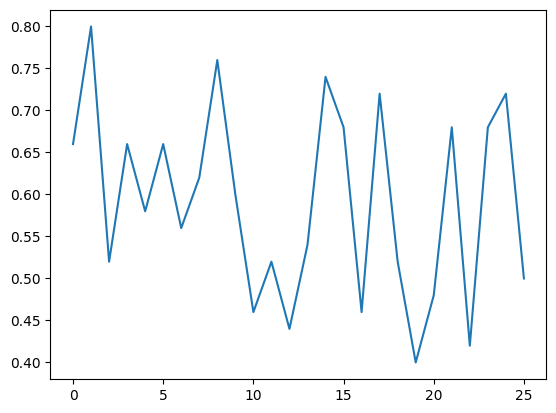

In [ ]:
vs_random_win_rate

import matplotlib.pyplot as plt

plt.plot(vs_random_win_rate)

## MCTS

In [20]:
class TreeNode():
    def __init__(self, parent=None, children={}, node_trials=0, wins=0, min_trials=5_000):
        self.parent = parent
        self.children = children
        self.node_trials = node_trials
        self.wins = wins
        self.min_trials = min_trials

    def next_move(self, game, epsilon=0):
        pre_moves = game.moves_played[:move_num]

        # Finding best move in real game. Epsilon is randomness (default is None)
        for move in game.moves_played:
            if move == -1:   # Tree is caught up
                break
            else:
                if move not in self.children.keys():  # If move not in game tree, add it
                    self.children[move] = TreeNode(parent=self, children={}, move_path=self.move_path+[move], node_trials=0, wins=0, score=math.inf)
                else:
                    return self.children[move].next_move(game, epsilon)   # Go one leaf further in tree
        """
        move = game.moves_played[move_num]
        pre_moves = []   # Moves for updating MCTS algo
        if move == -1:   # Tree is caught up
            pre_moves = game.moves_played[:move_num]   # Updating pre moves to be all but the most recent move
            pass
        else:   # Keep going until tree is caught up. CAN PROBABLY BE IMPROVED
            pre_moves.append(move)
            if move not in self.children.keys():  # If move not in game tree, add it
                self.children[move] = TreeNode(parent=self, children={}, move_path=self.move_path+[move], node_trials=0, wins=0, score=math.inf)

            return self.children[move].next_move(game, move_num+1)
        """

        if not self.children or self.node_trials < self.min_trials:   # If game tree didn't get this far or didn't play enough moves, train further
            print("Need to expand with trials: " + str(self.node_trials))
            mcts = MCTS(trials_in_test=self.min_trials-self.node_trials, num_rows=game.num_rows, num_cols=game.num_cols, in_a_row=game.in_a_row, head_node=self, pre_moves=pre_moves, pre_training=False)
            mcts.train_mcts()
            return self.best_child()
        else:
            if random.uniform(0, 1) < epsilon:   # Playing random move (not best tree move) weighted towards "better" moves
                print("playing Epsilon random move")
                child_dict = {move: child.wins for move, child in self.children.items()}
                maxWins = max(child_dict.values())
                non_max_child_wins = [wins for key, wins in child_dict.items() if wins < maxWins]
                non_max_child_wins_std = non_max_child_wins/np.sum(non_max_child_wins)
                cumulative_sum = np.cumsum(non_max_child_wins_std)

                rand_val = random.uniform(0,1)
                for i in range(len(cumulative_sum)):
                    if rand_val < cumulative_sum[i]:
                        best_val = non_max_child_wins[i]   # Random element choses (win total)
                        break

                keys = [key for key, wins in child_dict.items() if wins == best_val]
                return random.choice(keys)
            else:   # Play best tree move
                print("Playing Tree Move")
                return self.best_child()

        return False   # Shouldn't ever get here

    def best_child(self):
        # Finding best child
        child_dict = {move: child.wins for move, child in self.children.items()}
        print("child dict: " + str(child_dict))
        maxWins = max(child_dict.values())
        keys = [key for key, wins in child_dict.items() if wins == maxWins]
        return random.choice(keys)

    def evaluate_move(self, game):
        if game.move_num >= game.in_a_row*2-1:
            m = self.game_ending_move(game)
            if m:
                return m

        move_value_list = [-1*math.inf]*game.get_num_cols()

        AI_value_list = self.column_value(game, AI_turn=True)
        ##print("AI list: " + str(AI_value_list))
        for AI_move in [index for index, column in enumerate(game.get_state()) if column[-1]==0]:  # Iterating through legal moves
            game.play(AI_move)   ## "Play" move
            opp_value_list = self.column_value(game, AI_turn=False)
            opp_value = max(opp_value_list)

            ##print("opp list: " + str(opp_value_list))
            ##print("AI Move: " + str(AI_move) + "   opp_value: " + str(opp_value))
            move_value_list[AI_move] = AI_value_list[AI_move] - opp_value   # Net value is value of playing move minus opponents value if playing optimal next move
            game.unplay(AI_move)   # Unplaying move

        ##print("move value list: " + str(move_value_list))
        max_val = max(move_value_list)
        max_idx = [idx for idx, val in enumerate(move_value_list) if val==max_val]


        return random.choice(max_idx)

    def column_value(self, game, AI_turn=True):
        player_color = 1 if game.is_red_turn() else -1
        game_value_dict = [[0]*game.get_num_rows() for i in range(game.get_num_cols())]
        bottom_row_list = [0]*game.get_num_cols()   # Bottom playable row for each column
        move_vals = [0]*game.get_num_cols()    # Storing Move Values

        for color in [player_color, player_color*-1]:
            color_mult = 1 if color==player_color else -1
            for c in range(game.get_num_cols()):
                for r in range(game.get_num_rows()-1, -1, -1):
                    if game.get_state()[c][r] != 0:
                        bottom_row_list[c] = r+1 if r+1 < game.get_num_rows() else -1
                        break
                    else:
                        for move_coord in [(1,0), (1,-1), (0,-1), (-1,-1), (-1,0), (-1,1), (0,1), (1,1)]:   # Units steps for trying all game directions
                            color_count = 0
                            empty_count = 0
                            no_win = False
                            for i in range(1, game.in_a_row):   # looking at in a row - 1 moves
                                if c+move_coord[0]*i >= 0 and c+move_coord[0]*i < game.get_num_cols() and r+move_coord[1]*i >= 0 and r+move_coord[1]*i < game.get_num_rows():
                                    val = game.get_state()[c+move_coord[0]*i][r+move_coord[1]*i]
                                    if val == color:
                                        color_count+=1
                                    elif val == color*-1:
                                        no_win = True
                                        break
                                    else:
                                        empty_count+=1
                                else:   # Cant go enough moves in given direction
                                    no_win = True
                                    break
                            if not no_win:
                                score_mult = 1 if move_coord in [(0,1), (0,-1)] else 3   # Weight vertical wins less heavily
                                for i in range(game.in_a_row-1):  # Increment all empty squares in direction
                                    if game.get_state()[c+move_coord[0]*i][r+move_coord[1]*i] == 0:
                                        game_value_dict[c+move_coord[0]*i][r+move_coord[1]*i]  += score_mult*color_mult*(color_count*3 + empty_count)


        ##print("bottom row list: " + str(bottom_row_list))
        move_vals = [game_value_dict[i][bottom_row_list[i]]  if bottom_row_list[i] != -1 else -1*math.inf for i in range(game.get_num_cols())]
        ##print("move_vals: " + str(move_vals))

        """
        print("game value dict:")
        for r in range(game.get_num_rows()-1, -1, -1):
            for c in range(game.get_num_cols()):
                print(" " + str(game_value_dict[c][r]), end="\t")
            print("")
        print("")
        """

        return move_vals

    def game_ending_move(self, game):
        # If winning move immediately available, play it
        if game.move_num < game.in_a_row*2-1:   # Not far enough into game for winning move
            return None

        for idx in [index for index, column in enumerate(game.get_state()) if column[-1]==0]:   # Checking for winning move
            game.play(idx)
            if game.is_game_over():
                game.unplay(idx)
                return idx

            game.unplay(idx)

        for idx in [index for index, column in enumerate(game.get_state()) if column[-1]==0]:   # Checking to block opponent winning move
            game.play(idx, out_of_turn=True)  # Out of turn true since playing opponent's color
            if game.is_game_over():
                game.unplay(idx)
                return idx

            game.unplay(idx)

        return None

    def get_name(self):
        return "MCTS"

class MCTS():
    def __init__(self, trials_in_test=100000, num_rows=6, num_cols=7, in_a_row=4, head_node=TreeNode(parent=None, children={}, node_trials=0, wins=0), pre_moves=[], pre_training=True):
        self.trials_in_test = trials_in_test
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.in_a_row = in_a_row
        self.head_node = head_node  # Setting root node
        self.pre_moves = pre_moves
        self.pre_training = pre_training  # Whether pre-training or evaluating during real game play
        self.symmetry_list = []
        self.symmetry_dict = {}
        self.red_player_won = False   # If first player won
        self.a_time = 0
        self.b_time = 0
        self.c_time = 0
        self.d_time = 0
        self.e_time = 0

    def legal_moves(self, game):
        return [index for index, column in enumerate(game.get_state()) if column[-1]==0]

    def evaluate_children(self, node):
        # Finding child with highest UTC score
        first = True
        max_children = []
        max_children_moves = []
        max_val = None

        for move, child in node.children.items():   # Finding children with highest UCT scores
            uct_val = self.uct(child)
            if first or uct_val >= max_val:   # First go, so setting max values automatically
                if first or uct_val > max_val:   # If new max, reset lists
                    max_val = uct_val
                    max_children = [child]
                    max_children_moves = [move]
                else:   # If a tie, append to lists
                    max_children.append(child)
                    max_children_moves.append(move)

                if first:
                    first = False

        rand_idx = random.randint(0, len(max_children)-1)
        return max_children[rand_idx], max_children_moves[rand_idx]

    def uct(self, node, const=2):
        # Score for given node using provided formula
        return math.inf if node.node_trials==0 else node.wins/node.node_trials + const*math.sqrt(np.log(node.parent.node_trials)/node.node_trials)   # Can either be overall trials or parent trials

    def symmetrical_board(self, game):
        # See if board is symmetrical
        for r in range(game.get_num_rows()):
            for c in range(game.get_num_cols()//2):
                if game.get_state()[c][r] != game.get_state()[game.get_num_cols()-1-c][r]:
                    if game.get_state()[c][r] != 0 and game.get_state()[game.get_num_cols()-1-c][r] != 0:   # non-symmetry where both players moved so game can never again be symmetrical
                        return 'never'
                    else:
                        return 'not now'
        return 'yes'

    def game_ending_move(self, game):
        # If winning move immediately available, play it
        if game.move_num < game.in_a_row*2-2:   # Not far enough into game for winning move
            return None

        legal_moves = self.legal_moves(game)

        for out_of_turn in [False, True]:   # Start with AI move, the opp move
            for idx in legal_moves:
                b = time.time()
                game.play(idx, out_of_turn=out_of_turn)
                self.b_time += time.time()-b
                d = time.time()
                gm = game.is_game_over()
                self.d_time += time.time()-d
                if gm:
                    c = time.time()
                    game.unplay(idx)
                    self.c_time += time.time()-c
                    return idx
                c = time.time()
                game.unplay(idx)
                self.c_time += time.time()-c

        return None

    def set_up_opponent_win(self, game):
        # If winning move immediately available, play it
        if game.move_num < game.in_a_row*2-3: # Not far enough into game for winning move
            return []

        bad_moves_list = []
        for idx in self.legal_moves(game):
            game.play(idx)
            for opp_idx in self.legal_moves(game):
                game.play(opp_idx)
                if game.move_num >= (game.in_a_row)*2-2 and game.is_game_over():
                    game.unplay(opp_idx)
                    bad_moves_list.append(idx)
                    break

                game.unplay(opp_idx)

            game.unplay(idx)

        return bad_moves_list

    def rollout(self, focus_node, game):
        # Simulating the rest of the given game with random moves
        focus_player = -1 if game.is_red_turn() else 1   # Just played move so previous move was of the focus  player

        while True:
            move_to_play = None
            legal_moves = self.legal_moves(game)

            if game.move_num >= (game.in_a_row)*2-2:
                a = time.time()
                move_to_play = self.game_ending_move(game)
                self.a_time += time.time()-a
            """
            if not move_to_play and game.move_num >= (game.in_a_row)*2-3:   # Avoid moves that lead to immediate loss
                b = time.time()
                m = [x for x in legal_moves if x not in self.set_up_opponent_win(game)]
                if m:
                    move_to_play = random.choice(m)
                self.b_time += time.time()-b
            """
            if not move_to_play:   # Play random moves if no immediate game winning move
                move_to_play = random.choice(legal_moves)

            game.play(move_to_play)

            if game.move_num >= (game.in_a_row)*2-1 and game.is_game_over():
                outcome = 'tie' if not game.winner() else 'win' if game.winner() == focus_player else 'loss'
                self.red_player_won = True if game.winner() == 1 else False

                #game.board_print()
                #print("focus player: " + str(focus_player) + '  ' + str(outcome))
                b = time.time()
                self.update_wins(focus_node, outcome=outcome)
                self.b_time += time.time()-b
                c = time.time()
                ###self.update_twin_wins(game)
                self.c_time += time.time() - c
                return

    def update_wins(self, node, outcome='tie'):
        node.wins += 1 if outcome=='win' else 0
        ##print("updating wins")

        if node.parent is None:   # If head node, end updating
            return
        else:
            self.update_wins(node.parent, outcome if outcome=='tie' else 'win' if outcome=='loss' else 'loss')   # Update parent score if parent exists. Parent will have opposie result since it was the other player

    def update_twin_wins(self, game):
        # Updating twin nodes
        ##print("symmetry list: " + str(self.symmetry_dict))
        node = self.head_node

        for depth, move_list in self.symmetry_dict.items():
            fake_game = ConsoleCF(ai1=1, ai2=2, nn_ai=False, num_rows=self.num_rows, num_cols=self.num_cols, in_a_row=self.in_a_row)  # Init Game

            for idx in range(depth):   # Getting to node where branch happened
                if not node.children:   # If node doesn;t have children, create children
                    for move in self.legal_moves(fake_game):
                        node.children[move] = TreeNode(parent=node, children={}, move_path=node.move_path+[move], node_trials=0, wins=0)
                elif game.moves_played[idx] not in node.children.keys():   # If node exists, but different node, usually when winning move available
                    node.children[game.moves_played[idx]] = TreeNode(parent=node, children={}, move_path=node.move_path+[game.moves_played[idx]], node_trials=0, wins=0)

                node = node.children[game.moves_played[idx]]
                fake_game.play(game.moves_played[idx])   # Play move in fake game to see which moves are legal

            for m in range(len(move_list)):
                ##print("depth: " + str(depth))
                ##print("move list: " + str(move_list))
                if not node.children:   # If node doesn;t have children, create children
                    for move in self.legal_moves(fake_game):
                        node.children[move] = TreeNode(parent=node, children={}, move_path=node.move_path+[move],
                                                       move=move, node_trials=0, wins=0, score=self.node_score(node_trials=0, wins=0))
                if move_list[m] not in node.children.keys():   # If node exists, but different node, usually when winning move available
                    node.children[move_list[m]] = TreeNode(parent=node, children={}, move_path=node.move_path+[move_list[m]],
                                                           move=move_list[m], node_trials=0, wins=0, score=self.node_score(node_trials=0, wins=0))
                node = node.children[move_list[m]]
                fake_game.play(move_list[m])   # Play move in fake game to see which moves are legal

                if self.red_player_won and (m+depth)%2==0:
                    node.wins+=1
                elif not self.red_player_won and (m+depth)%2==1:
                    node.wins+=1

        child_dict = {child: child.wins for value, child in self.head_node.children.items()}
        ##print("head node children: " + str(child_dict))
        return

    def train_mcts(self):
        # Play games and update Tree
        """
        100k trial times 4x4 board 3 in a row
        total:                                  75 - 100  (1M 450s)
        setting up game and vars:               5.6
        assigning new nodes if winning move:    0.3
        assigning nodes if no winning move:     0.1
        updating node scores:                   12.3
        finding best child:                     9.8
        checking symmetry:                      4.8
        updating symm dict:                     0.8
        rolling out:                            42.9
        updating wins:                          0.5
        updating twin wins:                     8.7
        game over check:                        8.8
        playing moves                           1.8
        """
        total_time = 0
        a_time = 0
        b_time = 0
        c_time = 0
        d_time = 0
        e_time = 0
        f_time = 0
        g_time = 0
        h_time = 0
        i_time = 0
        j_time = 0
        k_time = 0
        l_time = 0

        total = time.time()

        for trial in range(self.trials_in_test):
            if trial%(self.trials_in_test/10)==0 and not self.pre_moves:
                print("TRIAL: " + str(trial))

            game = ConsoleCF(ai1=1, ai2=2, nn_ai=False, num_rows=self.num_rows, num_cols=self.num_cols, in_a_row=self.in_a_row, pre_moves=self.pre_moves)  # Init Game

            current_node = self.head_node   # Setting node that will change to head node before we start
            self.head_node.node_trials+=1    # Should equal total game trials
            self.red_player_won = False   # Seeing which player won
            self.symmetry_dict = {}
            never_symmetry_flag = False
            game_ending_move = None

            while True:
                game_ending_move = self.game_ending_move(game)   # Looking for game ending move. Will play it if available

                if not current_node.children:  # If terminal node, create children
                    #print("creating children")
                    if game_ending_move is not None:   # Add winning move node if available to expedite search tree
                        current_node.children[game_ending_move] = TreeNode(parent=current_node, children={}, node_trials=0, wins=0)
                    else:   # If no winning move available, create children
                        legal_moves = self.legal_moves(game)
                        for move in legal_moves:
                            current_node.children[move] = TreeNode(parent=current_node, children={}, node_trials=0, wins=0)

                if game_ending_move is not None:   # Find game ending move if it exists
                    if not self.pre_training:   # If in real game, just return the tree to play move. No further training needed
                        return self.head_node
                    best_child = current_node.children[game_ending_move]
                else:
                    best_child, best_child_move = self.evaluate_children(current_node)

                best_child.node_trials+=1

                #if not never_symmetry_flag and self.symmetrical_board(game)=='yes':   # If board is symmetrical, add move number where it was symmetrical
                  #  self.symmetry_dict[game.move_num] = []
                #elif self.symmetrical_board(game)=='never':  # Game can never again be symmetrical, so don't bother checking
                  #  never_symmetry_flag = True

                ##for l in self.symmetry_dict.values():   # Appending symmetrical lists with twin node
                 ##   l.append(game.get_num_cols()-best_child.value-1)

                move_to_play = game_ending_move if game_ending_move is not None else best_child_move   # Move to play
                game.play(move_to_play)  # playing move

                if game.move_num < (game.in_a_row)*2-1 or not game.is_game_over():   # Game not over
                    if best_child.node_trials==1:   # First time going to node, so will do a rollout simulation of the rest of the game
                        f = time.time()
                        self.rollout(best_child, game)
                        f_time += time.time() - f
                        #print("current wins: " + str(best_child.wins))
                        break
                    else:   # Keep playing, switch to selected child node
                        current_node = best_child

                else:   # If game is over, reward good nodes
                    outcome = 'win' if game.winner()!=0 else 'tie'
                    self.red_player_won = True if game.winner() == 1 else False
                    self.update_wins(best_child, outcome=outcome)   # Changed to best child instead of current node
                    ##self.update_twin_wins(game)
                    break


        total_time += time.time() - total
        print("total time: " + str(total_time))
        print("j time: " + str(j_time))
        print("a time: " + str(self.a_time))
        print("b time: " + str(self.b_time))
        print("c time: " + str(self.c_time))
        print("d time: " + str(self.d_time))
        print("e time: " + str(e_time))
        print("i time: " + str(i_time))
        print("f time: " + str(f_time))
        print("g time: " + str(g_time))
        print("h time: " + str(h_time))
        print("i time: " + str(i_time))
        print("k time: " + str(k_time))
        print("l time: " + str(l_time))


        return self.head_node

In [21]:
mcts = MCTS(trials_in_test=100_000, num_rows=6, num_cols=7, in_a_row=4)
process = psutil.Process()
print("MB Used Before: " + str(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2))  # in MB
head_of_tree = mcts.train_mcts()
process = psutil.Process()
print("MB Used After: " + str(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2))  # in MB

MB Used Before: 417.078125
TRIAL: 0
TRIAL: 10000
TRIAL: 20000
TRIAL: 30000
TRIAL: 40000
TRIAL: 50000
TRIAL: 60000
TRIAL: 70000
TRIAL: 80000
TRIAL: 90000
total time: 252.10135769844055
j time: 0
a time: 185.24220633506775
b time: 38.77041745185852
c time: 31.252172231674194
d time: 104.85944604873657
e time: 0
i time: 0
f time: 205.89176774024963
g time: 0
h time: 0
i time: 0
k time: 0
l time: 0
MB Used After: 467.86328125


In [ ]:
for child in head_of_tree.children.values():
    print("trials: " + str(child.node_trials) + "   wins: " + str(child.wins))

trials: 2860   wins: 1487
trials: 5493   wins: 3050
trials: 8453   wins: 4844
trials: 63099   wins: 39115
trials: 10503   wins: 6099
trials: 7187   wins: 4074
trials: 2405   wins: 1223


In [ ]:
for child in head_of_tree.children[3].children[0].children[4].children[0].children[2].children.values():
    print("trials: " + str(child.node_trials) + "   wins: " + str(child.wins))

trials: 0   wins: 0
trials: 1   wins: 0
trials: 0   wins: 0
trials: 1   wins: 0
trials: 1   wins: 0
trials: 1   wins: 0
trials: 1   wins: 0


In [ ]:
# Play game against human
game = ConsoleCF(ai1=head_of_tree, ai2=None,  num_rows=6, num_cols=7, in_a_row=4, goes_first=2)
game.play_out()
print(game.get_winner()+" has won.")
#1,2,1,1,2,1,2,0

Playing Tree Move
child dict: {0: 359, 1: 1149, 2: 2063, 3: 58637, 4: 2552, 5: 923, 6: 653}
 -  -  -  -  -  -  - 
 -  -  -  -  -  -  - 
 -  -  -  -  -  -  - 
 -  -  -  -  -  -  - 
 -  -  -  -  -  -  - 
 -  -  -  X  -  -  - 

What column would Human Player like to play: 
3
Playing Tree Move
child dict: {0: 234, 1: 365, 2: 1982, 3: 4464, 4: 925, 5: 1308, 6: 1651}
 -  -  -  -  -  -  - 
 -  -  -  -  -  -  - 
 -  -  -  -  -  -  - 
 -  -  -  -  -  -  - 
 -  -  -  X  -  -  - 
 -  -  O  X  -  -  - 

What column would Human Player like to play: 
4
Need to expand with trials: 2194
pre moves: [3, 2, 3, 3]
Playing Tree Move
child dict: {0: 141, 1: 129, 2: 278, 3: 111, 4: 154, 5: 276, 6: 493}
 -  -  -  -  -  -  - 
 -  -  -  -  -  -  - 
 -  -  -  -  -  -  - 
 -  -  -  O  -  -  - 
 -  -  -  X  -  -  - 
 -  -  O  X  -  -  X 

What column would Human Player like to play: 
5
Need to expand with trials: 98
pre moves: [3, 2, 3, 3, 6, 4]
Playing Tree Move
child dict: {0: 80, 1: 69, 2: 92, 3: 73, 4: 125, 5:

Exception: Invalid move

In [ ]:
game_count = 100
num_rows = 6
num_cols = 7
in_a_row = 4
mcts_wins = 0

for i in range(game_count):
    game = ConsoleCF(ai1=head_of_tree, ai2=JackAI(sim_mode=False, mm=False), nn_ai=False, num_rows=num_rows, num_cols=num_cols, in_a_row=in_a_row, goes_first=i%2+1, print_values=False)  # Init Game, alternate whether player 1 or 2 goes first
    #if i%2==0:
        #print("MCTS FIRST")
    ai1_epsilon=0.1
    ai2_epsilon=0.0
    game.play_out(ai1_epsilon, ai2_epsilon)

    if game.get_winner() == head_of_tree.get_name():
        #print("MCTS WON")
        mcts_wins+=1
    else:
        game.board_print()

print("MCTS win rate: " + str(mcts_wins/game_count))

TypeError: list indices must be integers or slices, not float

In [ ]:
def board_print(board):
        for r in range(5, -1, -1):
            for c in range(7):
               # print(("  " if len(str(s[c][r]))==1 else " ") + str('X' if s[c][r]==1 else 'O' if s[c][r]==-1 else '-'), end=" ")
                print(" " + str(board[c][r]), end=" ")
            print("")
        print("")

In [ ]:
MAX_MEMORY = 400_000
BATCH_SIZE = 1000
LR = 1e-3

record = 0
agent = Agent()
agent2 = Agent()
game = CFGame()
max_train_games = 100
max_no_improvement = 100
max_tries = 1
current_tries = 0
current_no_improvement = 0
print_debug = False
move_num = 0


while True and agent.n_games < max_train_games:

    state_old = np.array(game.get_state(), dtype=float)
    illegal_moves = [index for index, column in enumerate(state_old) if column[-1]!=0]   # illegal_moves
    state_old_flattened = list(chain.from_iterable(state_old))
    final_move = agent.get_action(state_old_flattened, illegal_moves, move_num, print_debug)
    move_num += 1   # Seeing what move in game, for epsilon decay
    game.play(final_move)
    state_new = np.array(game.get_state(), dtype=float)
    state_new_flattened = list(chain.from_iterable(state_new))
    reward = 1 if game.is_game_over() else 0   # Ties
    done = 1 if game.is_game_over() else 0

    agent.train_short_memory(state_old_flattened, final_move, reward, state_new_flattened, done)   # train short memory
    agent.remember(state_old_flattened, final_move, reward, state_new_flattened, done)   # remember

    if game.is_game_over():   # either agent 1 was winner or there was a tie
        print("GAME OVER: " + str(game.winner()))
        print(game.get_state())
        # train long memory, plot result
        agent.n_games += 1
        move_num = 0
        agent.train_long_memory()

        agent2.train_long_memory()

        game = CFGame()
    else:
        state_old = np.array(game.get_state(), dtype=float)
        illegal_moves = [index for index, column in enumerate(state_old) if column[-1]!=0]   # illegal_moves
        state_old_flattened = list(chain.from_iterable(state_old))
        final_move = agent2.get_action(state_old, illegal_moves, move_num, print_debug)
        move_num += 1   # Seeing what move in game, for epsilon decay
        game.play(final_move)
        state_new = np.array(game.get_state(), dtype=float)
        state_new_flattened = list(chain.from_iterable(state_new))
        reward = 1 if game.is_game_over() else 0
        done = 1 if game.is_game_over() else 0

        agent2.train_short_memory(state_old_flattened, final_move, reward, state_new_flattened, done)   # train short memory
        agent2.remember(state_old_flattened, final_move, reward, state_new_flattened, done)   # remember

        if game.is_game_over():
            print("GAME OVER: " + str(game.winner()))
            # train long memory, plot result
            agent.n_games += 1
            move_num = 0
            #print("agent2 memory: " + str(agent2.memory))
            agent2.train_long_memory()
            game = CFGame()

        """
        if score > record:
            record = score
            agent.model.save()
            current_no_improvement = 0
        else:
            current_no_improvement += 1
            if current_no_improvement >= max_no_improvement:
                if current_tries >= max_tries:
                    print("no_improvement for 50 games during game " + str(agent.n_games))
                    break
                else:
                    LR/=2  # Trying smaller learnign rate if no improvement for awhile
                    current_no_improvement = 0
                    print("New Learning Rate: " + str(LR))
                    current_tries += 1
        """

        #plot_scores.append(score)
        #total_score += score
        #mean_score = total_score / agent.n_games
        #plot_mean_scores.append(mean_score)
        ## plot(plot_scores, plot_mean_scores)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x42 and 126x256)

In [ ]:
 def is_winner(self):
        """ Returning whether there is a winner to the game
        Returns:
            boolean that is True if there is a winner and False otherwise
        """

        for i in range(self.num_cols):   # Checking up columns
            current_val = None   # Will hold current cell's assigned number
            cnt = 0   # counter for number of pieces in a row
            for j in range(self.num_rows):
                if self.state[i][j]==0:
                    cnt = 0
                    current_val = None
                    continue  # We are checking up columns so if we see a 0 then we cannot have x in a row

                if self.state[i][j]==current_val and current_val!=0:
                    cnt+=1
                    if cnt >= self.in_a_row:  # We have found a winner
                        #print("Won up column: " + str(i))
                        return True
                else:
                    current_val = self.state[i][j]
                    if current_val!=0:
                        cnt = 1  # We now have found 1 in a row

        for j in range(self.num_rows):   # Checking across rows
            current_val = None   # Will hold current cell's assigned number
            cnt = 0   # counter for number of pieces in a row
            for i in range(self.num_cols):
                if self.state[i][j]==0:
                    cnt = 0
                    current_val = None
                    if i > self.num_cols-self.in_a_row-1:  # Continue if there aren't enough places left in row to make x in a row
                        break

                if self.state[i][j]==current_val and current_val!=0:
                    cnt+=1
                    if cnt >= self.in_a_row:  # We have found a winner
                        #print("Won across row: " + str(j))
                        return True
                else:
                    current_val = self.state[i][j]
                    if current_val!=0:
                        cnt = 1  # We now have found 1 in a row

                    if i > self.num_cols-self.in_a_row:  # Continue if there aren't enough places left in row to make x in a row
                        break

        for i in range(self.num_cols):  # Checking forward diagonals (/)
            for j in range(self.num_rows):
                if j > (self.num_rows-self.in_a_row-1) or i > (self.num_cols-self.in_a_row-1) or self.state[i][j]==0:  # Cannot make enough in a row or no value in square
                    break

                cnt = 1   # Only looking up diagonal if we have a value in focus square
                current_val = self.state[i][j]
                failed = False

                if current_val!=0:
                    for x in range(i+1, self.num_cols):  # Going to check on the forward diagonal if values are the same
                        for y in range(j+1, self.num_rows):
                            if x+(self.num_rows-y)!=i+(self.num_rows-j):  # If not on diagonal, continue
                                continue

                            if self.state[x][y]==0:
                                cnt = 0
                                current_val = None
                                failed = True
                                break

                            if self.state[x][y]==current_val and current_val!=0:  # Found next piece in a row
                                cnt+=1
                                if cnt >= self.in_a_row:  # We have found a winner
                                    #print("Won forward diagonal: " + str(i) + " " + str(j))
                                    return True
                                break  # Move on to next column
                            else:
                                cnt = 0
                                current_val = None
                                failed = True
                                break

                        if failed:  # Getting out of nested loop if failure
                            break

            if i > self.num_cols-self.in_a_row:  # Continue if there aren't enough places left in row to make x in a row
                break

        for i in range(self.num_cols):  # Checking backward diagonals (\)
            for j in range(self.num_rows):
                if j < self.in_a_row-1 or i > (self.num_cols-self.in_a_row-1) or self.state[i][j]==0:  # Cannot make enough in a row or no value in square
                    continue

                cnt = 1   # Only looking up diagonal if we have a value in focus square
                current_val = self.state[i][j]
                failed = False

                if current_val!=0:
                    for x in range(i+1, self.num_cols):  # Going to check on the forward diagonal if values are the same
                        for y in range(j-1, -1, -1):  # Starting at top row and working down
                            if x+y!=i+j:  # If not on diagonal, continue
                                continue

                            if self.state[x][y]==current_val and current_val!=0:  # Found next piece in a row
                                cnt+=1
                                if cnt >= self.in_a_row:  # We have found a winner
                                    #print("Won backward diagonal: " + str(i) + " " + str(j))
                                    return True
                                break  # Move on to next column
                            else:
                                cnt = 0
                                current_val = None
                                failed = True
                                break

                        if failed:  # Getting out of nested loop if failure
                            break

            if i > self.num_cols-self.in_a_row:  # Continue if there aren't enough places left in row to make x in a row
                break


        return False
